In [ ]:
"""
Given the discrepancies in the amount of data in the municipality variable in the databases, we proceeded to do the following 
the following, taking advantage of the available information: 
"""

In [ ]:
#import of libraries

import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import geopandas as gpd
from scipy.stats import pearsonr, spearmanr,kendalltau
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from ydata_profiling import ProfileReport



In [4]:
# lectura de Bases de datos 
df_agricultura = pd.read_csv('data_agricultura_bolivar_clean.csv')
df_temperatura = pd.read_csv('TemperaturaB1620_clean.csv')
df_humedad = pd.read_csv('HumedadB1620_clean.csv')
df_precipitacion=pd.read_csv('precipitacionB1620_clean.csv')

In [ ]:
"""In order to have the information in a single DF, a union of the data is made only with those that match the municipalities of the agricultural database.
that match with the municipalities of the agricultural database.
considering the possible null values in some rows 
"""

In [ ]:
# Given the size of the Data Frame, I will perform a reduction by eliminating non-prescriptive columns. 

# 1. Temperature
print ('columnas en DF Temperatura',df_temperatura.columns)
print ('Tamaño inicial DF Temperatura',df_temperatura.shape)
# 2. Humidity
print ('columnas en DF Humedad',df_humedad.columns )
print ('Tamaño inicial DF Humedad',df_humedad.shape)
# 3 Precipitation
print('Columnas DF Precipitacion',df_precipitacion.columns)
print ('Tamaño inicial DF Precipitacion',df_precipitacion.shape)

columnas en DF Temperatura Index(['Unnamed: 0', 'CodigoEstacion', 'FechaObservacion', 'Departamento',
       'municipio', 'ZonaHidrografica', 'HoraObservacion', 'periodo',
       'Temperatura°C'],
      dtype='object')
Tamaño inicial DF Temperatura (155149, 9)
columnas en DF Humedad Index(['Unnamed: 0', 'CodigoEstacion', 'FechaObservacion', 'ValorObservado',
       'Departamento', 'municipio', 'ZonaHidrografica', 'periodo'],
      dtype='object')
Tamaño inicial DF Humedad (98726, 8)
Columnas DF Precipitacion Index(['Unnamed: 0', 'CodigoEstacion', 'Categoria', 'Entidad', 'Departamento',
       'municipio', 'IdParametro', 'Etiqueta', 'Frecuencia', 'Fecha', 'Valor',
       'Grado', 'periodo'],
      dtype='object')
Tamaño inicial DF Precipitacion (332, 13)


In [ ]:
#remove columna 
#1. Temperaturw
df_temperatura = df_temperatura.drop(columns=['HoraObservacion','FechaObservacion','ZonaHidrografica','Unnamed: 0', 'CodigoEstacion','Departamento'])
#2. Humidity
df_humedad = df_humedad.drop(columns=['Unnamed: 0', 'CodigoEstacion', 'FechaObservacion','Departamento', 'ZonaHidrografica'])
#3. Precipitation
df_precipitacion = df_precipitacion.drop(columns=['Unnamed: 0', 'CodigoEstacion', 'Categoria', 'Entidad', 'Departamento','IdParametro', 'Etiqueta', 'Frecuencia', 'Fecha', 'Grado'])

In [ ]:
# is grouped to avoid duplicate joins and reset to avoid changing the shape of the data.
# is consolidated into a single one when averaging
df_precipitacion = df_precipitacion.groupby(['municipio','periodo'])['Valor'].mean().reset_index(drop=False)
df_temperatura = df_temperatura.groupby(['municipio','periodo'])['Temperatura°C'].mean().reset_index(drop=False)
df_humedad = df_humedad.groupby(['municipio','periodo'])['ValorObservado'].mean().reset_index(drop=False)

In [ ]:
#remove check
print(df_temperatura.head())
print(df_humedad.head())
print(df_precipitacion.head())

  municipio  periodo  Temperatura°C
0      achi     2020      27.745045
1    arjona     2016      28.043074
2    arjona     2017      27.733673
3    arjona     2018      28.064574
4    arjona     2019      28.035254
  municipio  periodo  ValorObservado
0      achi     2020       82.638021
1    arjona     2016       81.405286
2    arjona     2017       83.154771
3    arjona     2018       81.246625
4    arjona     2019       78.499193
  municipio  periodo   Valor
0      achi     2016  5049.5
1      achi     2017  4671.2
2      achi     2018  4777.5
3      achi     2019  3914.5
4      achi     2020  4642.5


In [ ]:
#duplicated data check
print('Se encuentra valores duplicados en Temp : ',df_temperatura.duplicated().any())
print('Se encuentra valores duplicados en Humed : ',df_humedad.duplicated().any())
print('Se encuentra valores duplicados en Precip : ',df_precipitacion.duplicated().any())

Se encuentra valores duplicados en Temp :  False
Se encuentra valores duplicados en Humed :  False
Se encuentra valores duplicados en Precip :  False


In [ ]:
#check of data shape
print('Tamaño sin duplicados en temperatura : ',df_temperatura.shape)
print('Tamaño sin duplicados en Humedad : ',df_humedad.shape)
print('Tamaño sin duplicados en Precipitacion : ',df_precipitacion.shape)



Tamaño sin duplicados en temperatura :  (21, 3)
Tamaño sin duplicados en Humedad :  (22, 3)
Tamaño sin duplicados en Precipitacion :  (141, 3)


In [ ]:
# Unification of DataFrames
# It starts with the main one and the precipitation one with the key in municipality and period
df_agri_p = pd.merge(df_agricultura, df_precipitacion, on=['municipio', 'periodo'], how='left')  # This is the main one
# Union of the previous one with the humidity DataFrame
df_agri_ph = pd.merge(df_agri_p, df_humedad, on=['municipio', 'periodo'], how='left')
# Union of agriculture data with temperature data
df_agri_all = pd.merge(df_agri_ph, df_temperatura, on=['municipio', 'periodo'], how='left')

In [ ]:
print ('Tamaño Agri-Preci : ',df_agri_p.shape) # main DF
print ('Tamaño Agri-Climaticas:',df_agri_all.shape ) # DF with all data  

Tamaño Agri-Preci :  (2625, 12)
Tamaño Agri-Climaticas: (2625, 14)


In [ ]:
df_agri_all.shape # shape before group by 

(7471, 23)

In [ ]:
# let´s see some data of achi in municipio
df_temperatura[(df_temperatura['municipio']=='achi')& (df_temperatura['periodo']== 2016)]

Empty DataFrame
Columns: [municipio, periodo, Temperatura°C]
Index: []

In [ ]:
#df_agri_all[(df_agri_all['municipio']== 'achi') &( df_agri_all['periodo'] == 2019)]
df_agri_all
# before situation with the data (before group by)

Unnamed: 0_x  coddpto_x departamento_x codmunicipio_x municipio  \
0                0         13        Bolívar         13,006      achi   
1                1         13        Bolívar         13,006      achi   
2                2         13        Bolívar         13,006      achi   
3                3         13        Bolívar         13,006      achi   
4                4         13        Bolívar         13,006      achi   
...            ...        ...            ...            ...       ...   
7466          2620         13        Bolívar         13,894  zambrano   
7467          2621         13        Bolívar         13,894  zambrano   
7468          2622         13        Bolívar         13,894  zambrano   
7469          2623         13        Bolívar         13,894  zambrano   
7470          2624         13        Bolívar         13,894  zambrano   

            cultivo_x  periodo  area_sembrada_ha_x  area_cosechada_ha_x  \
0            aguacate     2016                80.0                 80.0   
1             ahuyama     2016                15.0                 15.0   
2             ahuyama     2016                50.0                 25.0   
3         arroz riego     2016               861.0                600.0   
4         arroz riego     2016               600.0                600.0   
...               ...      ...                 ...                  ...   
7466           tabaco     2020                20.0                 20.0   
7467          patilla     2020                20.0                 20.0   
7468            melon     2020                20.0                 20.0   
7469             yuca     2020              1000.0               1000.0   
7470  palma de aceite     2020              1430.0               1430.0   

      produccion_t_x  ...  coddpto_y  departamento_y  codmunicipio_y  \
0              960.0  ...        NaN             NaN             NaN   
1              225.0  ...        NaN             NaN             NaN   
2              300.0  ...        NaN             NaN             NaN   
3             2700.0  ...        NaN             NaN             NaN   
4             3000.0  ...        NaN             NaN             NaN   
...              ...  ...        ...             ...             ...   
7466            40.0  ...        NaN             NaN             NaN   
7467           240.0  ...        NaN             NaN             NaN   
7468           240.0  ...        NaN             NaN             NaN   
7469         12000.0  ...        NaN             NaN             NaN   
7470          3575.0  ...        NaN             NaN             NaN   

      cultivo_y area_sembrada_ha_y area_cosechada_ha_y produccion_t_y  \
0           NaN                NaN                 NaN            NaN   
1           NaN                NaN                 NaN            NaN   
2           NaN                NaN                 NaN            NaN   
3           NaN                NaN                 NaN            NaN   
4           NaN                NaN                 NaN            NaN   
...         ...                ...                 ...            ...   
7466        NaN                NaN                 NaN            NaN   
7467        NaN                NaN                 NaN            NaN   
7468        NaN                NaN                 NaN            NaN   
7469        NaN                NaN                 NaN            NaN   
7470        NaN                NaN                 NaN            NaN   

      rendimiento_tha_y  Temperatura°C  ValorObservado  
0                   NaN            NaN             NaN  
1                   NaN            NaN             NaN  
2                   NaN            NaN             NaN  
3                   NaN            NaN             NaN  
4                   NaN            NaN             NaN  
...                 ...            ...             ...  
7466                NaN            NaN             NaN  
7467                NaN       

In [ ]:
# Columns are renamed for better identification. 
df_agri_all.rename(columns={
    'Valor':'Precipitación mm',
    'ValorObservado':'Humedad %'
}, inplace=True)

print(df_agri_all.columns)

Index(['Unnamed: 0', 'coddpto', 'departamento', 'codmunicipio', 'municipio',
       'cultivo', 'periodo', 'area_sembrada_ha', 'area_cosechada_ha',
       'produccion_t', 'rendimiento_tha', 'Precipitación mm', 'Humedad %',
       'Temperatura°C'],
      dtype='object')


In [ ]:
# check of null value in new dataframe
df_agri_all.info()

# it is seem some null values in  precipitación . temperatura , humedad columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2625 entries, 0 to 2624
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         2625 non-null   int64  
 1   coddpto            2625 non-null   int64  
 2   departamento       2625 non-null   object 
 3   codmunicipio       2625 non-null   object 
 4   municipio          2625 non-null   object 
 5   cultivo            2625 non-null   object 
 6   periodo            2625 non-null   int64  
 7   area_sembrada_ha   2625 non-null   float64
 8   area_cosechada_ha  2625 non-null   float64
 9   produccion_t       2625 non-null   float64
 10  rendimiento_tha    2625 non-null   float64
 11  Precipitación mm   1671 non-null   float64
 12  Humedad %          329 non-null    float64
 13  Temperatura°C      311 non-null    float64
dtypes: float64(7), int64(3), object(4)
memory usage: 287.2+ KB


In [ ]:
# Proceed to identify which municipalities these null values belong to and in which year they are missing
# Identification of municipalities with null data in  climate column
def identificar_nulos_climaticos(df, columna, anos=5):
    municipios_nulos = []  # Store the municipalities with unique values
    # Review the DF with a loop
    for i, row in df.iterrows():
        if pd.isnull(row[columna]):  # Check if the value in the column is null
            municipios_nulos.append(row['municipio'])  # Add the municipality corresponding to that null value
    # Establish only unique values
    municipios_nulos_uni = set(municipios_nulos)

    return municipios_nulos_uni



In [ ]:
# Function to identify the years where there are null data in the climatic variables by municipality
def identificar_nulo_clima(df, columna):
    # Filter the DF for null data in the Clima column
    df_nul_clima = df[df[columna].isnull()]

    # In this dictionary, we store the municipalities and years with null climate values
    municipio_ano_null = {}

    # Loop through the dataframe saving those municipality and year data
    for i, row in df_nul_clima.iterrows():
        # Extract municipality and year
        muni = row['municipio']  # Municipality row i
        peri = row['periodo']  # Period or year row i

        # Add to the dictionary and check if it is already there or not
        if muni not in municipio_ano_null:
           municipio_ano_null[muni] = {peri}
        else:  # If the municipality is already in the dictionary
            municipio_ano_null[muni].add(peri)
    return municipio_ano_null


In [28]:
identificar_nulos_climaticos(df_agri_all,'Precipitación mm')


{'altos del rosario',
 'arroyohondo',
 'barranco de loba',
 'calamar',
 'cantagallo',
 'clemencia',
 'cordoba',
 'el peñon',
 'margarita',
 'montecristo',
 'morales',
 'norosi',
 'rio viejo',
 'rioviejo',
 'san cristobal',
 'san martin de loba',
 'santa catalina',
 'santa rosa',
 'soplaviento',
 'talaigua nuevo',
 'tiquisio',
 'tiquisio puerto rico',
 'turbana',
 'villanueva'}

In [38]:
identificar_nulos_climaticos(df_agri_all,'Humedad %')

{'achi',
 'altos del rosario',
 'arenal',
 'arroyohondo',
 'barranco de loba',
 'calamar',
 'cantagallo',
 'cartagena de indias',
 'cicuco',
 'clemencia',
 'cordoba',
 'el peñon',
 'hatillo de loba',
 'magangue',
 'mahates',
 'margarita',
 'maria la baja',
 'mompos',
 'montecristo',
 'morales',
 'norosi',
 'pinillos',
 'regidor',
 'rio viejo',
 'rioviejo',
 'san cristobal',
 'san estanislao',
 'san fernando',
 'san jacinto',
 'san jacinto del cauca',
 'san juan nepomuceno',
 'san martin de loba',
 'san pablo',
 'santa catalina',
 'santa rosa',
 'santa rosa del sur',
 'simiti',
 'soplaviento',
 'talaigua nuevo',
 'tiquisio',
 'tiquisio puerto rico',
 'turbaco',
 'turbana',
 'villanueva',
 'zambrano'}

In [32]:
identificar_nulo_clima(df_agri_all,'Precipitación mm')

{'altos del rosario': {2016, 2017, 2018, 2019, 2020},
 'barranco de loba': {2016},
 'calamar': {2016, 2017, 2018, 2019, 2020},
 'clemencia': {2016, 2017, 2018, 2019, 2020},
 'cordoba': {2016},
 'el peñon': {2016, 2017, 2018, 2019, 2020},
 'margarita': {2016},
 'montecristo': {2016, 2017, 2018, 2019, 2020},
 'norosi': {2016, 2017, 2018, 2019, 2020},
 'rio viejo': {2016, 2017, 2018},
 'san cristobal': {2016, 2017, 2018, 2019, 2020},
 'san martin de loba': {2016},
 'santa catalina': {2016, 2017, 2018, 2019, 2020},
 'santa rosa': {2016, 2017, 2018, 2019, 2020},
 'soplaviento': {2016, 2017, 2018, 2019, 2020},
 'talaigua nuevo': {2016, 2017, 2018, 2019, 2020},
 'tiquisio': {2016, 2017, 2018},
 'turbana': {2016, 2017, 2018, 2019, 2020},
 'villanueva': {2016, 2017, 2018, 2019, 2020},
 'arroyohondo': {2017, 2018, 2019, 2020},
 'cantagallo': {2017, 2018, 2019, 2020},
 'morales': {2017, 2018, 2019, 2020},
 'rioviejo': {2019, 2020},
 'tiquisio puerto rico': {2019, 2020}}

In [34]:
identificar_nulo_clima(df_agri_all,'Humedad %')

{'achi': {2016, 2017, 2018, 2019},
 'altos del rosario': {2016, 2017, 2018, 2019, 2020},
 'arenal': {2016, 2017, 2018, 2019, 2020},
 'barranco de loba': {2016, 2017, 2018, 2019, 2020},
 'calamar': {2016, 2017, 2018, 2019, 2020},
 'cartagena de indias': {2016, 2017, 2018},
 'cicuco': {2016, 2017, 2018, 2019, 2020},
 'clemencia': {2016, 2017, 2018, 2019, 2020},
 'cordoba': {2016, 2017, 2018, 2019, 2020},
 'el peñon': {2016, 2017, 2018, 2019, 2020},
 'hatillo de loba': {2016, 2017, 2018, 2019, 2020},
 'magangue': {2016, 2017, 2018, 2019, 2020},
 'mahates': {2016, 2017, 2018, 2019, 2020},
 'margarita': {2016, 2017, 2018, 2019, 2020},
 'maria la baja': {2016, 2017, 2018, 2019, 2020},
 'montecristo': {2016, 2017, 2018, 2019, 2020},
 'norosi': {2016, 2017, 2018, 2019, 2020},
 'pinillos': {2016, 2017, 2018, 2019, 2020},
 'regidor': {2016, 2017, 2018, 2019, 2020},
 'rio viejo': {2016, 2017, 2018},
 'san cristobal': {2016, 2017, 2018, 2019, 2020},
 'san estanislao': {2016, 2017, 2018, 2019, 2020

In [35]:
identificar_nulo_clima(df_agri_all,'Temperatura°C')

{'achi': {2016, 2017, 2018, 2019},
 'altos del rosario': {2016, 2017, 2018, 2019, 2020},
 'arenal': {2016, 2017, 2018, 2019, 2020},
 'barranco de loba': {2016, 2017, 2018, 2019, 2020},
 'calamar': {2016, 2017, 2018, 2019, 2020},
 'cartagena de indias': {2016, 2017, 2018},
 'cicuco': {2016, 2017, 2018, 2019, 2020},
 'clemencia': {2016, 2017, 2018, 2019, 2020},
 'cordoba': {2016, 2017, 2018, 2019, 2020},
 'el peñon': {2016, 2017, 2018, 2019, 2020},
 'hatillo de loba': {2016, 2017, 2018, 2019, 2020},
 'magangue': {2016, 2017, 2018, 2019, 2020},
 'mahates': {2016, 2017, 2018, 2019, 2020},
 'margarita': {2016, 2017, 2018, 2019, 2020},
 'maria la baja': {2016, 2017, 2018, 2019, 2020},
 'montecristo': {2016, 2017, 2018, 2019, 2020},
 'norosi': {2016, 2017, 2018, 2019, 2020},
 'pinillos': {2016, 2017, 2018, 2019, 2020},
 'regidor': {2016, 2017, 2018, 2019, 2020},
 'rio viejo': {2016, 2017, 2018},
 'san cristobal': {2016, 2017, 2018, 2019, 2020},
 'san estanislao': {2016, 2017, 2018, 2019, 2020

In [ ]:
# proceed to input the climatic data for each municipality into the corresponding data 
# a dictionary is made for the average annual value of the climatic variable by region. 
# source: https://clima.fedearroz.com.co/bolivar/
# source: https://es.weatherspark.com/

# 1. Temperatura
lista_null_temperatura= {'achi':30,
 'altos del rosario':31,
 'arenal':29,
 'arroyohondo':29,
 'barranco de loba':31,
 'calamar':31,
 'cantagallo':28,
 'cartagena de indias':28,
 'cicuco':30,
 'clemencia':31,
 'cordoba':36,
 'el peñon':35,
 'hatillo de loba':36,
 'magangue':36,
 'mahates':34,
 'margarita':36,
 'maria la baja':34,
 'mompos':36,
 'montecristo':34,
 'morales':33,
 'pinillos':36,
 'regidor':34,
 'rio viejo':34,
 'rioviejo':34,
 'san cristobal':36,
 'san jacinto':35,
 'san pablo':34,
 'santa catalina':31,
 'santa rosa':32,
 'santa rosa del sur':29,
 'simiti':32,
 'soplaviento':34,
 'tiquisio':35,
 'turbaco':31,
 'turbana':31,
 'villanueva':34,
 'zambrano':36}
#2. precipitación 
lista_null_precipitación= {
    'altos del rosario':483,
 'arroyohondo': 109,
 'barranco de loba' :351,
 'calamar':106 ,
 'cantagallo': 198,
 'clemencia':139,
 'cordoba': 134,
 'el peñon':104,
 'margarita': 275,
 'montecristo': 555,
 'morales':144,
 'rio viejo': 211,
 'rioviejo': 211,
 'san cristobal':116,
 'san martin de loba': 260,
 'santa catalina':230,
 'santa rosa': 248,
 'soplaviento':117,
 'tiquisio':137,
 'turbana':142,
 'villanueva':194}

# 3. Humedad
lista_null_humedad = {'achi':90,
 'altos del rosario':83,
 'arenal':97,
 'arroyohondo': 98,
 'barranco de loba':79.5,
 'calamar':97,
 'cantagallo':100,
 'cartagena de indias':100,
 'cicuco': 91,
 'clemencia':100,
 'cordoba':92,
 'el peñon':92,
 'hatillo de loba':79,
 'magangue':93,
 'mahates':100,
 'margarita':86,
 'maria la baja':100,
 'mompos':86.5,
 'montecristo':98,
 'morales':100,
 'pinillos':84,
 'regidor':96,
 'rio viejo':97,
 'rioviejo':97,
 'san cristobal':97,
 'san jacinto':95,
 'san pablo':99,
 'santa catalina':100,
 'santa rosa':100,
 'santa rosa del sur':97,
 'simiti':99,
 'soplaviento':100,
 'tiquisio':97,
 'turbaco':100,
 'turbana':100,
 'villanueva':75,
 'zambrano':92}



In [ ]:
# Climate data imputation for missing values using the following function
def imputacion_clima(df, columna, imputacion):
    # The data in the 'imputacion' dictionary contains only the municipalities with missing climate values
    # Iterate over each value in the dictionary
    for municipio, valor in imputacion.items():
        # Access and filter the dataframe
        # First the conditions, then the column where it will be modified (1, 2)
        df.loc[(df['municipio'] == municipio) & (df[columna].isnull()), columna] = valor
    return df  # Returns the dataframe with the imputation in the climate column


In [ ]:
df_agri_all.info()
# even with the imputations there are null data in the climate variables, data for which no information was obtained.
# these null data represent between 14% and 5%. 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2625 entries, 0 to 2624
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         2625 non-null   int64  
 1   coddpto            2625 non-null   int64  
 2   departamento       2625 non-null   object 
 3   codmunicipio       2625 non-null   object 
 4   municipio          2625 non-null   object 
 5   cultivo            2625 non-null   object 
 6   periodo            2625 non-null   int64  
 7   area_sembrada_ha   2625 non-null   float64
 8   area_cosechada_ha  2625 non-null   float64
 9   produccion_t       2625 non-null   float64
 10  rendimiento_tha    2625 non-null   float64
 11  Precipitación mm   1671 non-null   float64
 12  Humedad %          329 non-null    float64
 13  Temperatura°C      311 non-null    float64
dtypes: float64(7), int64(3), object(4)
memory usage: 287.2+ KB


In [18]:
imputacion_clima(df_agri_all,'Temperatura°C',lista_null_temperatura)

Unnamed: 0  coddpto departamento codmunicipio municipio  \
0              0       13      Bolívar       13,006      achi   
1              1       13      Bolívar       13,006      achi   
2              2       13      Bolívar       13,006      achi   
3              3       13      Bolívar       13,006      achi   
4              4       13      Bolívar       13,006      achi   
...          ...      ...          ...          ...       ...   
2620        2620       13      Bolívar       13,894  zambrano   
2621        2621       13      Bolívar       13,894  zambrano   
2622        2622       13      Bolívar       13,894  zambrano   
2623        2623       13      Bolívar       13,894  zambrano   
2624        2624       13      Bolívar       13,894  zambrano   

              cultivo  periodo  area_sembrada_ha  area_cosechada_ha  \
0            aguacate     2016              80.0               80.0   
1             ahuyama     2016              15.0               15.0   
2             ahuyama     2016              50.0               25.0   
3         arroz riego     2016             861.0              600.0   
4         arroz riego     2016             600.0              600.0   
...               ...      ...               ...                ...   
2620           tabaco     2020              20.0               20.0   
2621          patilla     2020              20.0               20.0   
2622            melon     2020              20.0               20.0   
2623             yuca     2020            1000.0             1000.0   
2624  palma de aceite     2020            1430.0             1430.0   

      produccion_t  rendimiento_tha  Precipitación mm  Humedad %  \
0            960.0             12.0          5049.500        NaN   
1            225.0             15.0          5049.500        NaN   
2            300.0             12.0          5049.500        NaN   
3           2700.0              4.5          5049.500        NaN   
4           3000.0              5.0          5049.500        NaN   
...            ...              ...               ...        ...   
2620          40.0              2.0          1176.525        NaN   
2621         240.0             12.0          1176.525        NaN   
2622         240.0             12.0          1176.525        NaN   
2623       12000.0             12.0          1176.525        NaN   
2624        3575.0              3.0          1176.525        NaN   

      Temperatura°C  
0              30.0  
1              30.0  
2              30.0  
3              30.0  
4              30.0  
...             ...  
2620           36.0  
2621           36.0  
2622           36.0  
2623           36.0  
2624           36.0  

[2625 rows x 14 columns]

In [19]:
imputacion_clima(df_agri_all,'Humedad %',lista_null_humedad)

Unnamed: 0  coddpto departamento codmunicipio municipio  \
0              0       13      Bolívar       13,006      achi   
1              1       13      Bolívar       13,006      achi   
2              2       13      Bolívar       13,006      achi   
3              3       13      Bolívar       13,006      achi   
4              4       13      Bolívar       13,006      achi   
...          ...      ...          ...          ...       ...   
2620        2620       13      Bolívar       13,894  zambrano   
2621        2621       13      Bolívar       13,894  zambrano   
2622        2622       13      Bolívar       13,894  zambrano   
2623        2623       13      Bolívar       13,894  zambrano   
2624        2624       13      Bolívar       13,894  zambrano   

              cultivo  periodo  area_sembrada_ha  area_cosechada_ha  \
0            aguacate     2016              80.0               80.0   
1             ahuyama     2016              15.0               15.0   
2             ahuyama     2016              50.0               25.0   
3         arroz riego     2016             861.0              600.0   
4         arroz riego     2016             600.0              600.0   
...               ...      ...               ...                ...   
2620           tabaco     2020              20.0               20.0   
2621          patilla     2020              20.0               20.0   
2622            melon     2020              20.0               20.0   
2623             yuca     2020            1000.0             1000.0   
2624  palma de aceite     2020            1430.0             1430.0   

      produccion_t  rendimiento_tha  Precipitación mm  Humedad %  \
0            960.0             12.0          5049.500       90.0   
1            225.0             15.0          5049.500       90.0   
2            300.0             12.0          5049.500       90.0   
3           2700.0              4.5          5049.500       90.0   
4           3000.0              5.0          5049.500       90.0   
...            ...              ...               ...        ...   
2620          40.0              2.0          1176.525       92.0   
2621         240.0             12.0          1176.525       92.0   
2622         240.0             12.0          1176.525       92.0   
2623       12000.0             12.0          1176.525       92.0   
2624        3575.0              3.0          1176.525       92.0   

      Temperatura°C  
0              30.0  
1              30.0  
2              30.0  
3              30.0  
4              30.0  
...             ...  
2620           36.0  
2621           36.0  
2622           36.0  
2623           36.0  
2624           36.0  

[2625 rows x 14 columns]

In [20]:
imputacion_clima(df_agri_all,'Precipitación mm',lista_null_precipitación)

Unnamed: 0  coddpto departamento codmunicipio municipio  \
0              0       13      Bolívar       13,006      achi   
1              1       13      Bolívar       13,006      achi   
2              2       13      Bolívar       13,006      achi   
3              3       13      Bolívar       13,006      achi   
4              4       13      Bolívar       13,006      achi   
...          ...      ...          ...          ...       ...   
2620        2620       13      Bolívar       13,894  zambrano   
2621        2621       13      Bolívar       13,894  zambrano   
2622        2622       13      Bolívar       13,894  zambrano   
2623        2623       13      Bolívar       13,894  zambrano   
2624        2624       13      Bolívar       13,894  zambrano   

              cultivo  periodo  area_sembrada_ha  area_cosechada_ha  \
0            aguacate     2016              80.0               80.0   
1             ahuyama     2016              15.0               15.0   
2             ahuyama     2016              50.0               25.0   
3         arroz riego     2016             861.0              600.0   
4         arroz riego     2016             600.0              600.0   
...               ...      ...               ...                ...   
2620           tabaco     2020              20.0               20.0   
2621          patilla     2020              20.0               20.0   
2622            melon     2020              20.0               20.0   
2623             yuca     2020            1000.0             1000.0   
2624  palma de aceite     2020            1430.0             1430.0   

      produccion_t  rendimiento_tha  Precipitación mm  Humedad %  \
0            960.0             12.0          5049.500       90.0   
1            225.0             15.0          5049.500       90.0   
2            300.0             12.0          5049.500       90.0   
3           2700.0              4.5          5049.500       90.0   
4           3000.0              5.0          5049.500       90.0   
...            ...              ...               ...        ...   
2620          40.0              2.0          1176.525       92.0   
2621         240.0             12.0          1176.525       92.0   
2622         240.0             12.0          1176.525       92.0   
2623       12000.0             12.0          1176.525       92.0   
2624        3575.0              3.0          1176.525       92.0   

      Temperatura°C  
0              30.0  
1              30.0  
2              30.0  
3              30.0  
4              30.0  
...             ...  
2620           36.0  
2621           36.0  
2622           36.0  
2623           36.0  
2624           36.0  

[2625 rows x 14 columns]

In [ ]:
# we check for duplicate data with the new df with the imputations
df_agri_all.duplicated().any()

np.False_

In [ ]:
# a new base without null data is created 
df_agri_n=df_agri_all.dropna(subset=['Precipitación mm','Humedad %','Temperatura°C'])

In [23]:
df_agri_n.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2251 entries, 0 to 2624
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         2251 non-null   int64  
 1   coddpto            2251 non-null   int64  
 2   departamento       2251 non-null   object 
 3   codmunicipio       2251 non-null   object 
 4   municipio          2251 non-null   object 
 5   cultivo            2251 non-null   object 
 6   periodo            2251 non-null   int64  
 7   area_sembrada_ha   2251 non-null   float64
 8   area_cosechada_ha  2251 non-null   float64
 9   produccion_t       2251 non-null   float64
 10  rendimiento_tha    2251 non-null   float64
 11  Precipitación mm   2251 non-null   float64
 12  Humedad %          2251 non-null   float64
 13  Temperatura°C      2251 non-null   float64
dtypes: float64(7), int64(3), object(4)
memory usage: 263.8+ KB


In [24]:
df_agri_n.drop(columns=['Unnamed: 0'], inplace=True)

C:\Users\Cristin Rodriguez\AppData\Local\Temp\ipykernel_15200\3617892007.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agri_n.drop(columns=['Unnamed: 0'], inplace=True)


In [18]:
df_agri_n.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2251 entries, 0 to 2624
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   coddpto            2251 non-null   int64  
 1   departamento       2251 non-null   object 
 2   codmunicipio       2251 non-null   object 
 3   municipio          2251 non-null   object 
 4   cultivo            2251 non-null   object 
 5   periodo            2251 non-null   int64  
 6   area_sembrada_ha   2251 non-null   float64
 7   area_cosechada_ha  2251 non-null   float64
 8   produccion_t       2251 non-null   float64
 9   rendimiento_tha    2251 non-null   float64
 10  Precipitación mm   2251 non-null   float64
 11  Humedad %          2251 non-null   float64
 12  Temperatura°C      2251 non-null   float64
dtypes: float64(7), int64(2), object(4)
memory usage: 246.2+ KB


In [ ]:
# modifications of values in municipality to be fixed 
df_agri_n.loc[df_agri_n['municipio']=='rioviejo','municipio'] = 'rio viejo'

In [ ]:
#unique value function definition 
def unique(df,columna):
    unico= [] 
    for i in df[columna]:
        if i not in unico:
            unico.append(i)    
    return unico


In [ ]:
unique(df_agri_n,'cultivo')

In [64]:
print("Descripción de las variables climáticas y de rendimiento agrícola:")
df_agri_n[['rendimiento_tha','Precipitación mm','Humedad %','Temperatura°C']].describe()

Descripción de las variables climáticas y de rendimiento agrícola:


rendimiento_tha  Precipitación mm    Humedad %  Temperatura°C
count      2251.000000       2251.000000  2251.000000    2251.000000
mean          6.550036       1263.588807    91.741646      32.355993
std           7.386633       1048.352159    10.010149       2.980761
min           0.000000        104.000000    46.307638      21.851254
25%           1.500000        230.000000    84.820923      30.000000
50%           4.000000       1281.560000    96.000000      33.000000
75%          10.000000       1886.900000   100.000000      35.000000
max          90.000000       5049.500000   100.000000      38.343902

In [ ]:
# Descriptive statistical analysis by municipality or period and by crop
columnasdes = ['rendimiento_tha', 'Precipitación mm', 'Humedad %', 'Temperatura°C']
por_m_p = df_agri_n.groupby(['municipio', 'cultivo', 'periodo'])[columnasdes].describe()
pd.set_option('display.max_rows', 10)  # None means there is no limit
pd.set_option('display.max_columns', None)  # None means there is no limit
por_m_p


rendimiento_tha                                     \
                                     count  mean  std   min   25%   50%   75%   
municipio cultivo  periodo                                                      
achi      aguacate 2016                1.0  12.0  NaN  12.0  12.0  12.0  12.0   
                   2017                1.0  15.0  NaN  15.0  15.0  15.0  15.0   
                   2018                1.0  16.0  NaN  16.0  16.0  16.0  16.0   
                   2019                1.0   5.0  NaN   5.0   5.0   5.0   5.0   
                   2020                1.0   5.0  NaN   5.0   5.0   5.0   5.0   
...                                    ...   ...  ...   ...   ...   ...   ...   
zambrano  yuca     2016                1.0   8.0  NaN   8.0   8.0   8.0   8.0   
                   2017                1.0   8.0  NaN   8.0   8.0   8.0   8.0   
                   2018                1.0  10.0  NaN  10.0  10.0  10.0  10.0   
                   2019                2.0  10.0  0.0  10.0  10.0  10.0  10.0   
                   2020                2.0  12.0  0.0  12.0  12.0  12.0  12.0   

                                 Precipitación mm                           \
                             max            count      mean  std       min   
municipio cultivo  periodo                                                   
achi      aguacate 2016     12.0              1.0  5049.500  NaN  5049.500   
                   2017     15.0              1.0  4671.200  NaN  4671.200   
                   2018     16.0              1.0  4777.500  NaN  4777.500   
                   2019      5.0              1.0  3914.500  NaN  3914.500   
                   2020      5.0              1.0  4642.500  NaN  4642.500   
...                          ...              ...       ...  ...       ...   
zambrano  yuca     2016      8.0              1.0  1106.200  NaN  1106.200   
                   2017      8.0              1.0  1401.675  NaN  1401.675   
                   2018     10.0              1.0   830.600  NaN   830.600   
                   2019     10.0              2.0   967.750  0.0   967.750   
                   2020     12.0              2.0  1176.525  0.0  1176.525   

                                                                   Humedad %  \
                                 25%       50%       75%       max     count   
municipio cultivo  periodo                                                     
achi      aguacate 2016     5049.500  5049.500  5049.500  5049.500       1.0   
                   2017     4671.200  4671.200  4671.200  4671.200       1.0   
                   2018     4777.500  4777.500  4777.500  4777.500       1.0   
                   2019     3914.500  3914.500  3914.500  3914.500       1.0   
                   2020     4642.500  4642.500  4642.500  4642.500       1.0   
...                              ...       ...       ...       ...       ...   
zambrano  yuca     2016     1106.200  1106.200  1106.200  1106.200       1.0   
                   2017     1401.675  1401.675  1401.675  1401.675       1.0   
                   2018      830.600   830.600   830.600   830.600       1.0   
                   2019      967.750   967.750   967.750   967.750       2.0   
                   2020     1176.525  1176.525  1176.525  1176.525       2.0   

                                                                             \
                                 mean  std        min        25%        50%   
municipio cultivo  periodo                                                    
achi      aguacate 2016     90.000000  NaN  90.000000  90.000000  90.000000   
                   2017     90.000000  NaN  90.000000  90.000000  90.000000   
                   2018     90.000000  NaN  90.000000  90.000000  90.000000   
                   2019     90.000000  NaN  90.000000  90.000000  90.000000   
                   2020     82.638021  NaN  82.638021  82.638021  82.638021   
...                               ...  ...    

In [ ]:
"""We want to see how the climatic variables (temperature, humidity, precipitation)
and crop yield are distributed. This can help us identify patterns, outliers, and the overall shape of the distribution."""
def analisis_grafico(df, columnax, columnay, leyenda):
    # Set the size of the canvas
    plt.figure(figsize=(15, 6))
    # Configure the canvas
    plt.subplot(1, 3, 1)
    # Histogram
    # with a kernel density estimation (KDE) to see the shape of the distribution.
    sns.histplot(df[columnax], kde=True, bins=20)
    plt.title(f'Histogram of {columnax}')
    plt.xlabel(f'{columnax}')
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(1, 3, 2)
    sns.boxplot(x=df[columnax])
    plt.title(f'Boxplot of {columnax}')

    # Dispersion
    plt.subplot(1, 3, 3)
    sns.scatterplot(data=df, x=columnax, y=columnay)  # , hue= leyenda) #kws={'alpha':0.5}, line_kws={'color':'red'},ci=None)
    plt.title(f'Dispersion {columnay} vs {columnax}')
    plt.xlabel(f'{columnax}')
    plt.ylabel(f'{columnay}')
    # Move the legend outside the plot
    plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=6)

    plt.xticks(rotation=90)

    plt.tight_layout()
    plt.show()


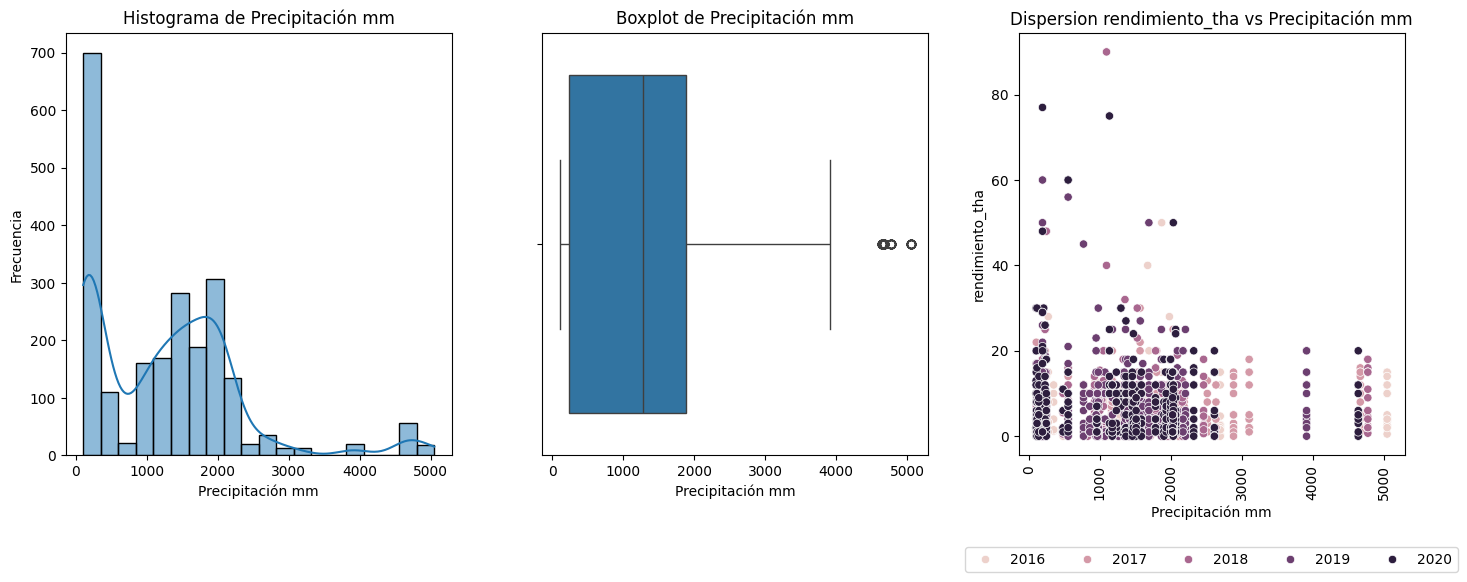

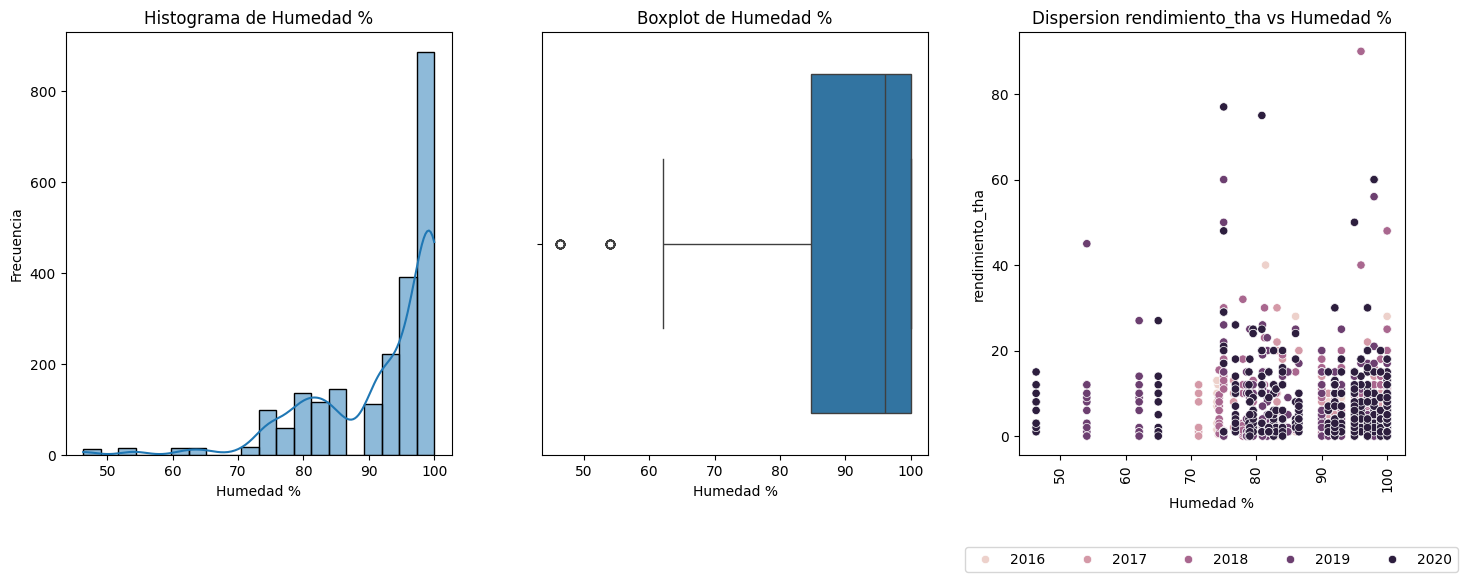

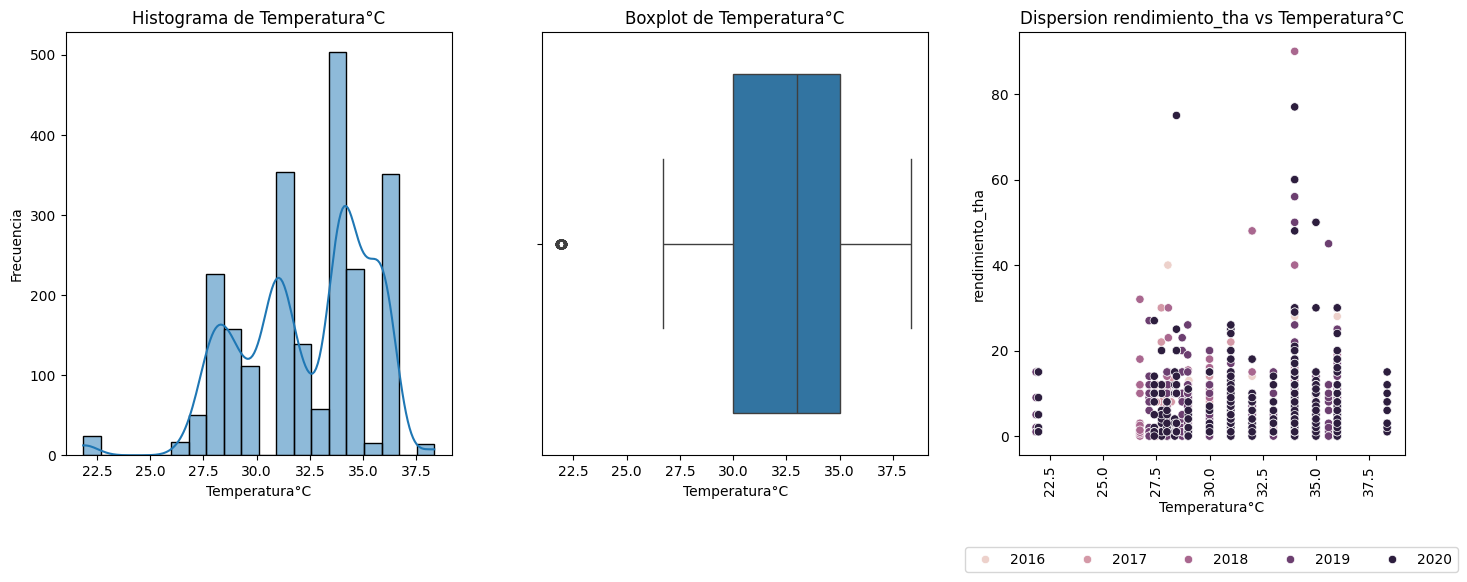

In [241]:
Lista_grafico=['Precipitación mm','Humedad %','Temperatura°C']

for i in Lista_grafico:
    analisis_grafico(df_agri_n,i,'rendimiento_tha','periodo')

In [ ]:
# Graphical analysis of dispersion

def analisis_graf_dispersion(df, columnax, columnay, leyenda): 
    # Dispersion
    plt.figure(figsize=(15, 9))
    sns.regplot(data=df, x=columnax, y=columnay, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'}, ci=None)
    plt.title(f'Dispersion {columnay} vs {columnax}')
    plt.xlabel(f'{columnax}')
    plt.ylabel(f'{columnay}')
    # Move the legend outside the plot
    plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=6)

    plt.xticks(rotation=90)

    plt.tight_layout()
    plt.show()


C:\Users\Cristin Rodriguez\AppData\Local\Temp\ipykernel_20660\1827036657.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(0.5,-0.2), loc='upper center', ncol=6 )


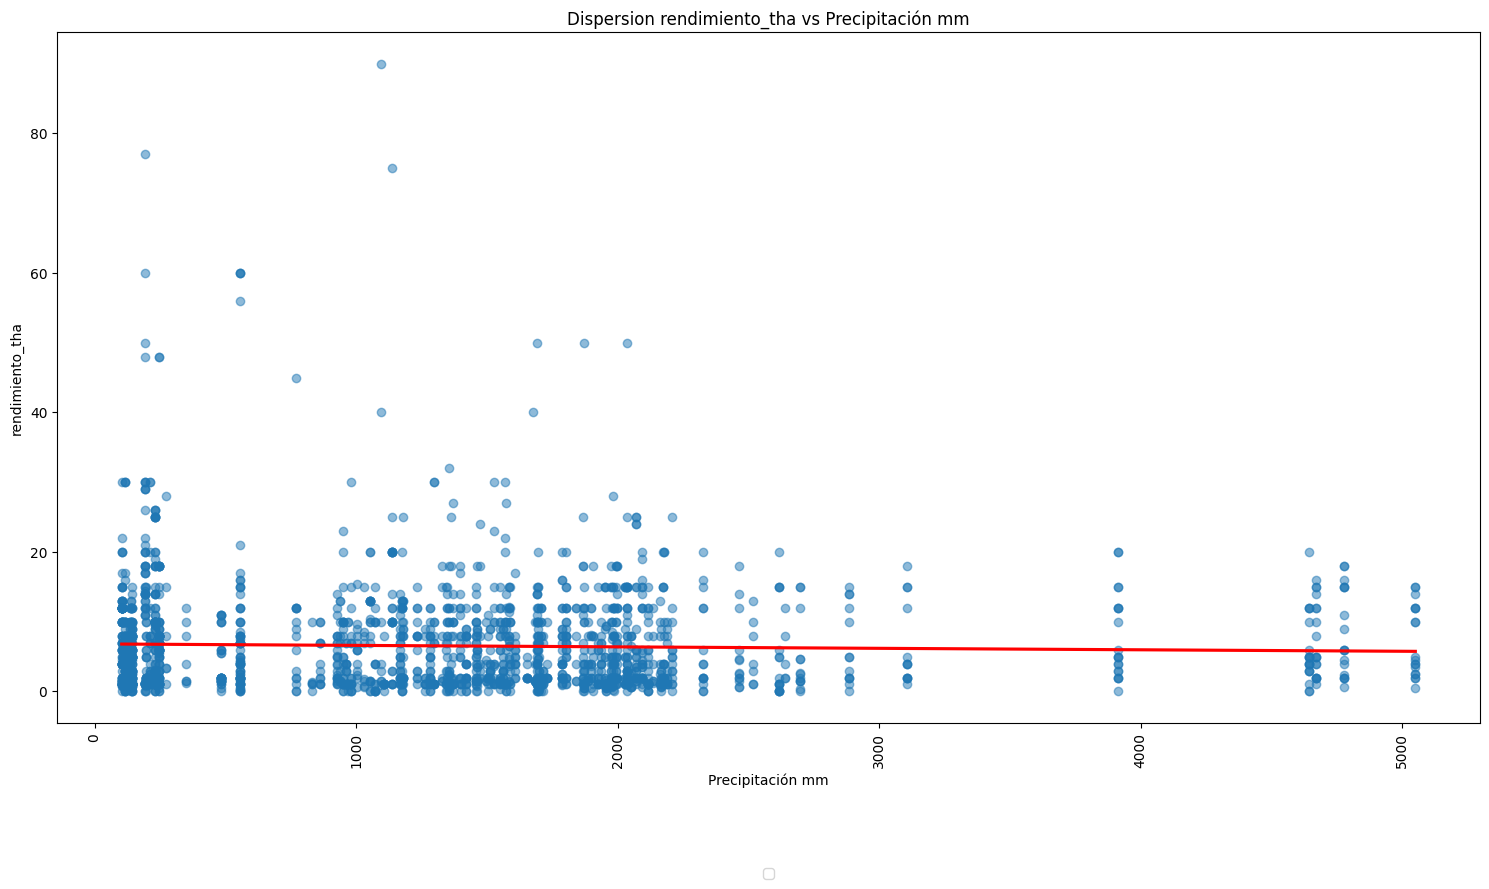

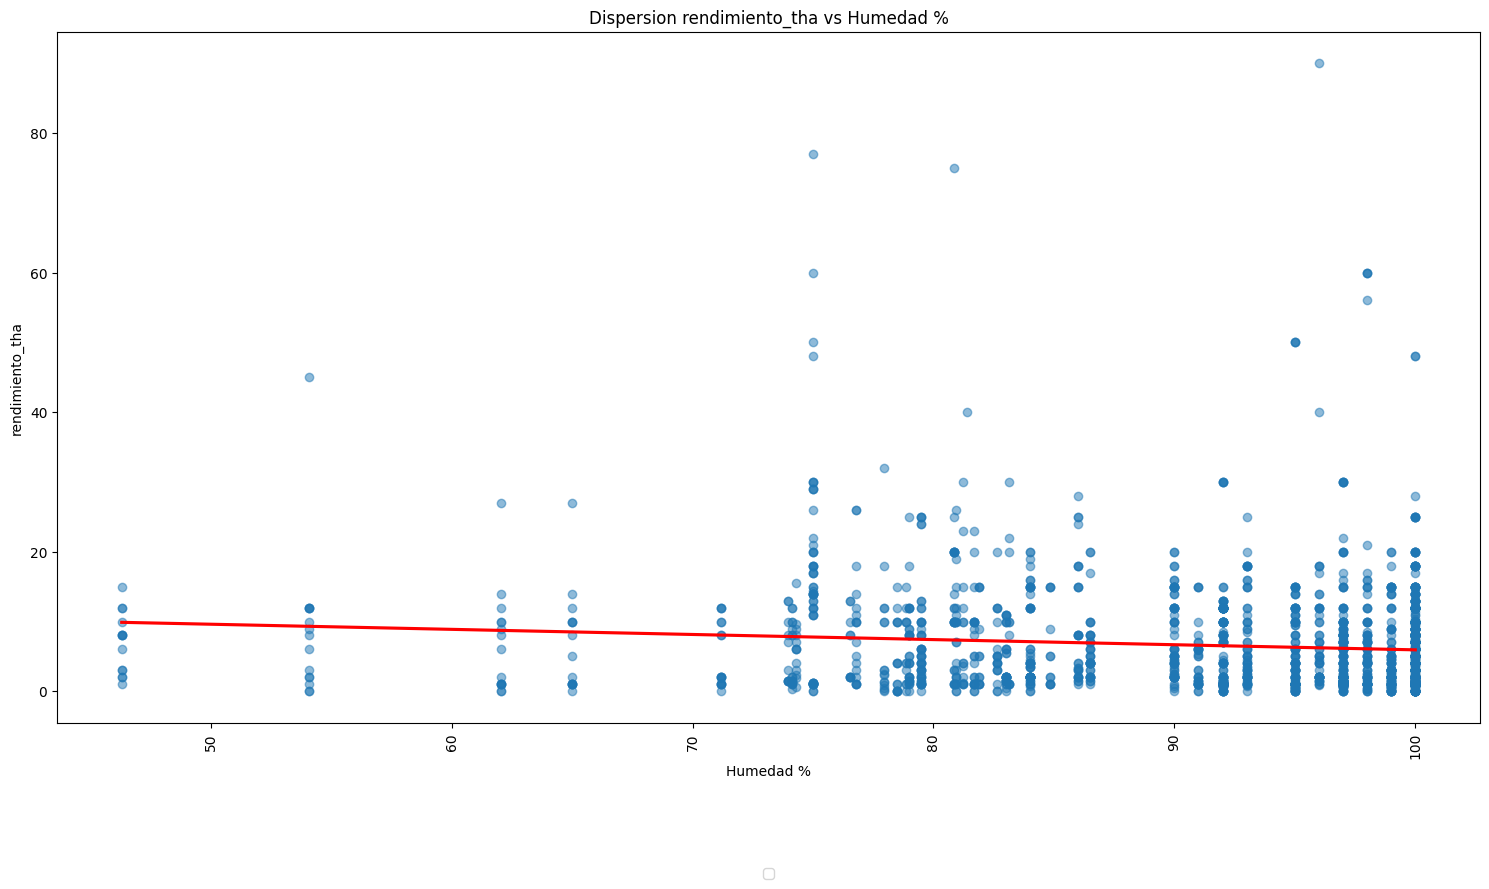

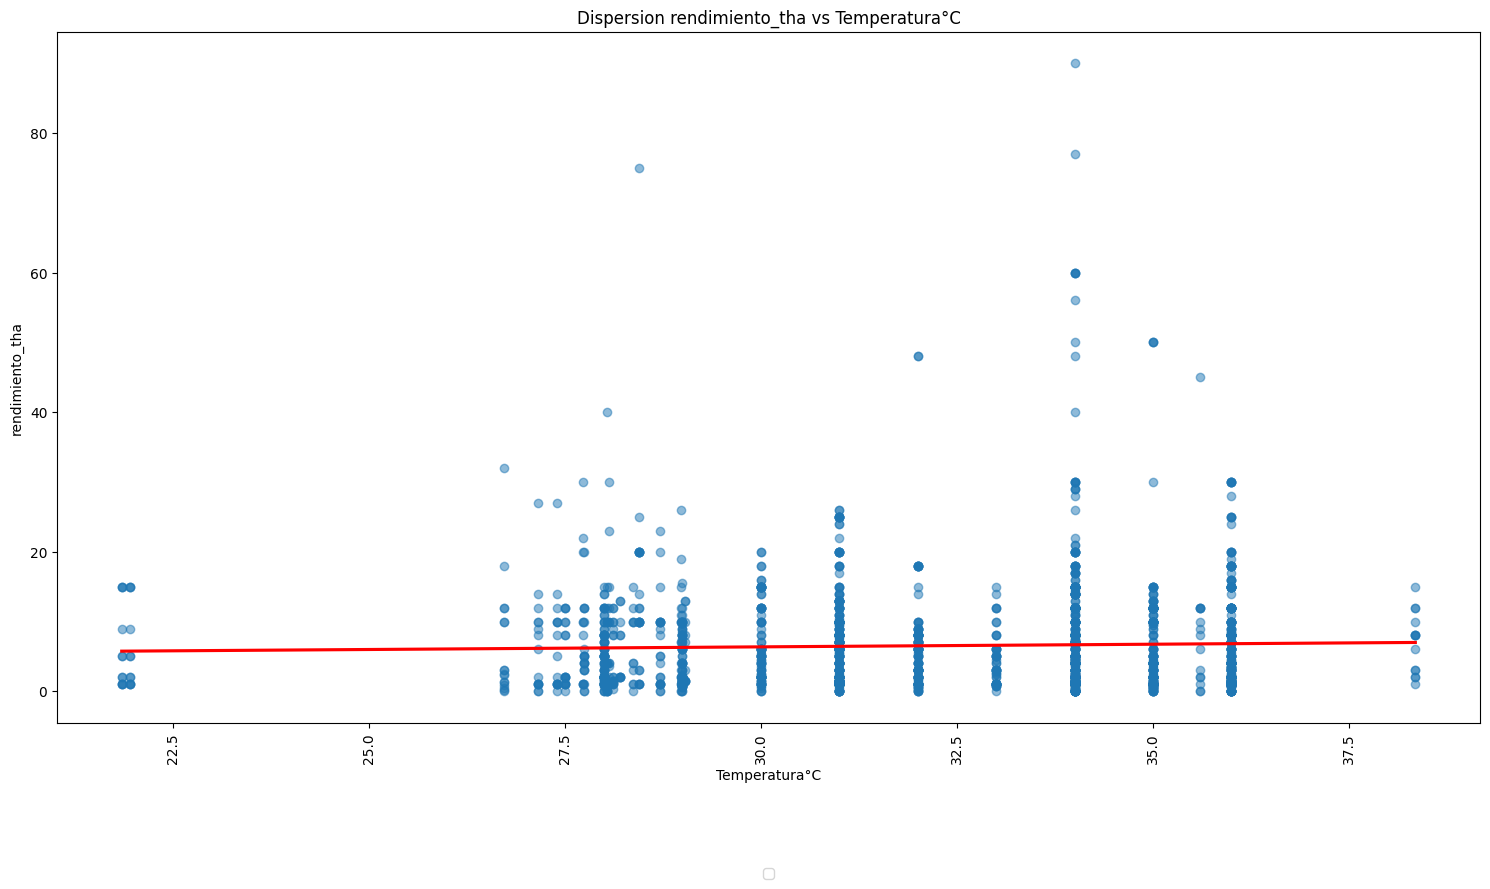

In [ ]:
#  Display of the dispersion graph
#Let's visualise the trend of my variables  
Lista_grafico_dispersion=['Precipitación mm','Humedad %','Temperatura°C']

for i in Lista_grafico_dispersion:
    analisis_graf_dispersion(df_agri_n,i,'rendimiento_tha','cultivo')

In [ ]:
### Make the evaluation of the relationship between the varieties 
# crop, municipality and period with respect to the climatic ones. 

# grouped by crop, period and municipality
df_grupo_cpm= df_agri_n.groupby(['municipio','cultivo','periodo']).agg({
   'Precipitación mm':'mean',
   'Humedad %':'mean',
   'Temperatura°C':'mean',
   'rendimiento_tha':'mean' 
}).reset_index()

In [93]:
df_grupo_cpm

municipio   cultivo  periodo  Precipitación mm  Humedad %  Temperatura°C  \
0         achi  aguacate     2016          5049.500  90.000000      30.000000   
1         achi  aguacate     2017          4671.200  90.000000      30.000000   
2         achi  aguacate     2018          4777.500  90.000000      30.000000   
3         achi  aguacate     2019          3914.500  90.000000      30.000000   
4         achi  aguacate     2020          4642.500  82.638021      27.745045   
...        ...       ...      ...               ...        ...            ...   
1602  zambrano      yuca     2016          1106.200  92.000000      36.000000   
1603  zambrano      yuca     2017          1401.675  92.000000      36.000000   
1604  zambrano      yuca     2018           830.600  92.000000      36.000000   
1605  zambrano      yuca     2019           967.750  92.000000      36.000000   
1606  zambrano      yuca     2020          1176.525  92.000000      36.000000   

      rendimiento_tha  
0                12.0  
1                15.0  
2                16.0  
3                 5.0  
4                 5.0  
...               ...  
1602              8.0  
1603              8.0  
1604             10.0  
1605             10.0  
1606             12.0  

[1607 rows x 7 columns]

In [ ]:
# pearson's correlation coefficient calculation
Lista_grafico_dispersion=['Precipitación mm','Humedad %','Temperatura°C']

for i in Lista_grafico_dispersion:
    pearson_coef,_= pearsonr(df_agri_n['rendimiento_tha'],df_agri_n[i])
    print(f'Coeficiente de Pearson {i};',pearson_coef)

Coeficiente de Pearson Precipitación mm; -0.02993073791456349
Coeficiente de Pearson Humedad %; -0.09949878992062948
Coeficiente de Pearson Temperatura°C; 0.030513505159423665


In [ ]:
# Pearson
"""
Precipitación mm (-0.0299): Indicates a very weak negative correlation. That is, there is very little or no linear relationship between precipitation and yield.
Humedad % (-0.0995): Also shows a weak negative correlation. This suggests that humidity and yield are not linearly correlated.
Temperatura°C (0.0305): This value is close to zero, indicating that there is no significant linear correlation between temperature and yield.
"""


In [167]:
# calculo de coeficiente de correlación de Spearman 
Lista_grafico_dispersion=['Precipitación mm','Humedad %','Temperatura°C']

for i in Lista_grafico_dispersion:
    spearman_coef,_= spearmanr(df_agri_n['rendimiento_tha'],df_agri_n[i])
    print(f'Coeficiente de Spearman {i};',spearman_coef)

Coeficiente de Spearman Precipitación mm; -0.014480702147463598
Coeficiente de Spearman Humedad %; -0.04196152917678093
Coeficiente de Spearman Temperatura°C; 0.008364679790845887


In [ ]:
# Spearman 
"""
Precipitación mm (-0.0145): Indicates a very weak negative correlation. Being very close to zero suggests that there is no monotonic relationship between precipitation and yield.
Humedad % (-0.0419): Again, a very weak negative correlation. This reinforces the idea that there is no significant relationship.
Temperatura°C (0.0084): This value is also close to zero, suggesting that there is no significant monotonic relationship between temperature and yield.
"""


In [ ]:
# since the relationship between the data is non-linear 
# we calculate the kendall's correlation coefficient
Lista_grafico_dispersion=['Precipitación mm','Humedad %','Temperatura°C']

for i in Lista_grafico_dispersion:
    kendall_coef, p_valor_kendall = kendalltau(df_agri_n[i],df_agri_n['rendimiento_tha'])
    print(f'Coeficiente de Kendall {i}: {kendall_coef}, p_valor:{p_valor_kendall}')



Coeficiente de Kendall Precipitación mm: -0.00960305874414262, p_valor:0.5100819697832313
Coeficiente de Kendall Humedad %: -0.027405929778884175, p_valor:0.07123060143756525
Coeficiente de Kendall Temperatura°C: 0.005534577516430527, p_valor:0.7173442596375947


In [ ]:
# Visualization of dispersion with polynomial transformation
# Graphical analysis of dispersion 

def graf_dispersion_poli(df, columnax, columnay, leyenda, grado=2): 
    # Dispersion
    plt.figure(figsize=(15, 9))
    # Plot points 
    sns.scatterplot(data=df, x=columnax, y=columnay, alpha=0.5)

    # Polynomial fit
    coeficiente = np.polyfit(df[columnax], df[columnay], grado)
    polinomio = np.poly1d(coeficiente)  # Creation of polynomial function

    # X-axis values for plotting the fit line
    x = np.linspace(df[columnax].min(), df[columnax].max(), 100)
    y = polinomio(x)

    # Plotting the fit line
    plt.plot(x, y, color='red', label=f'Polynomial fit degree {grado}')

    # Labels
    plt.title(f'Dispersion {columnay} vs {columnax}')
    plt.xlabel(f'{columnax}')
    plt.ylabel(f'{columnay}')
    # Move the legend outside the graph
    plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=6)

    plt.xticks(rotation=90)

    plt.tight_layout()
    plt.show()


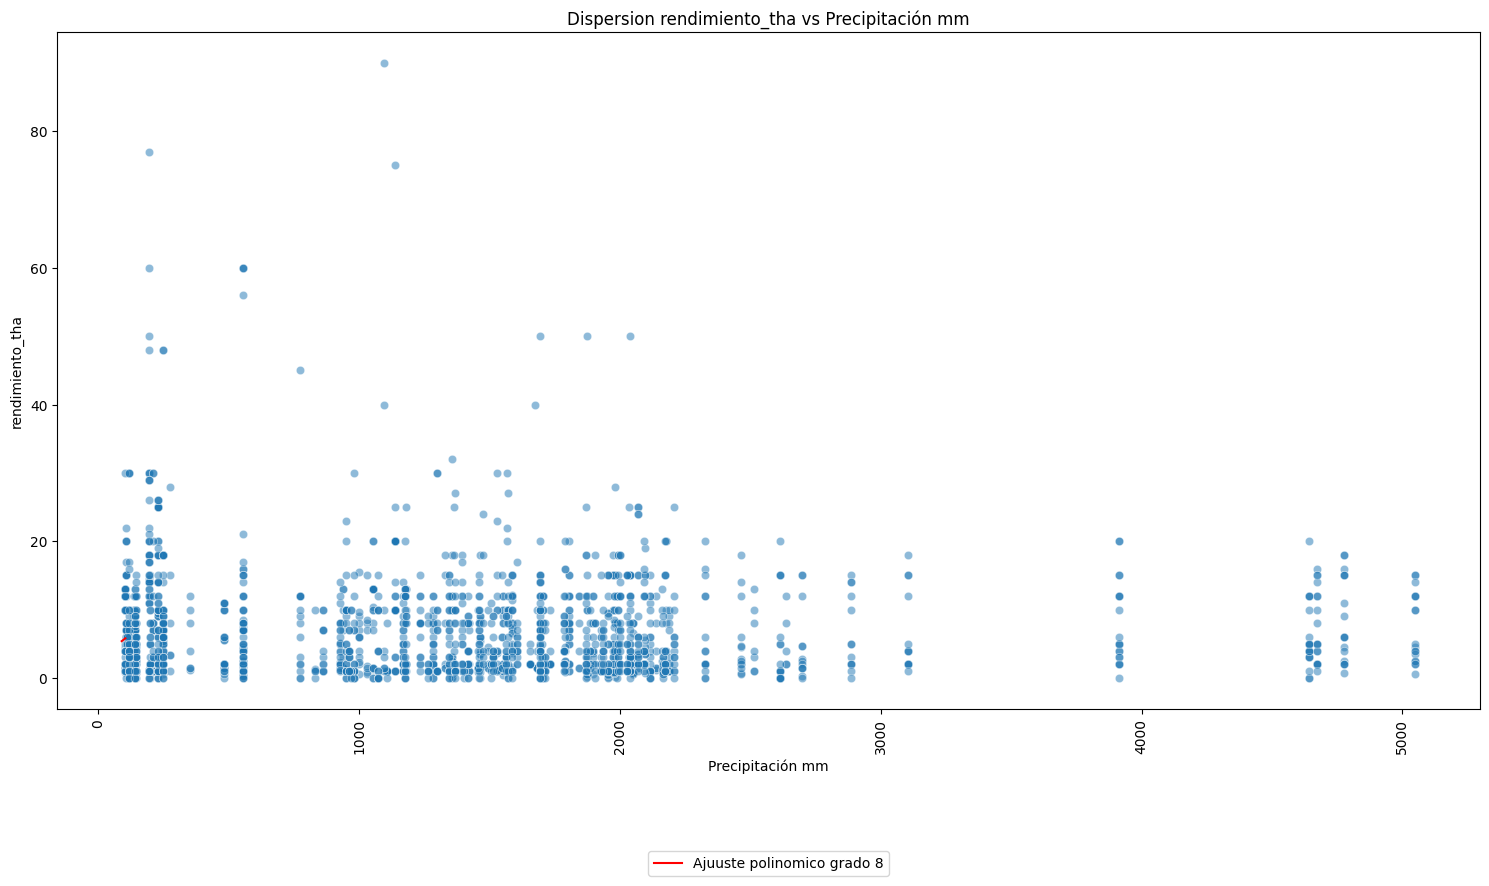

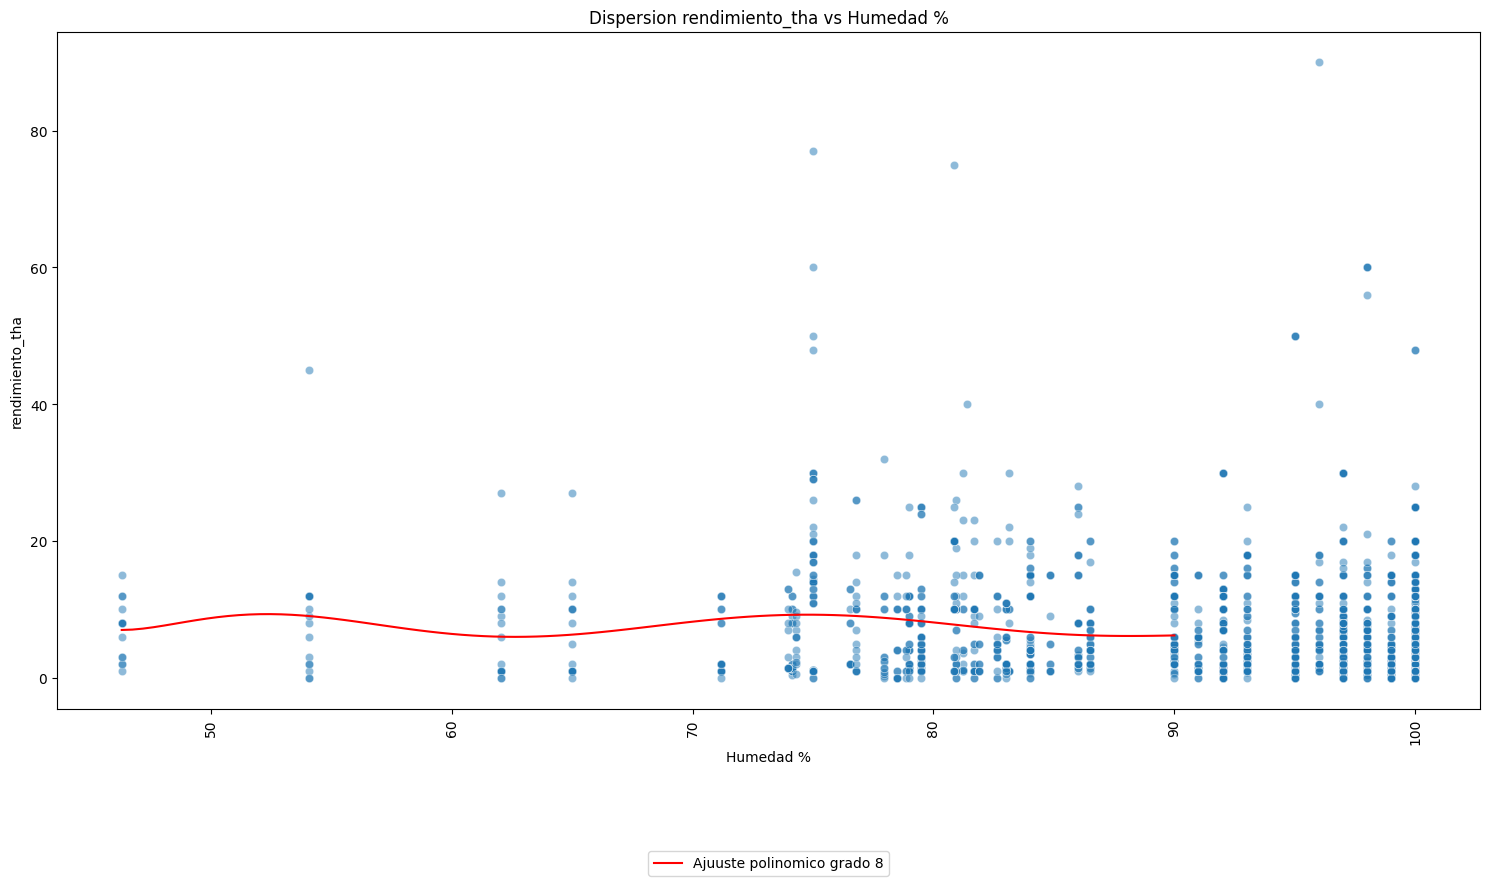

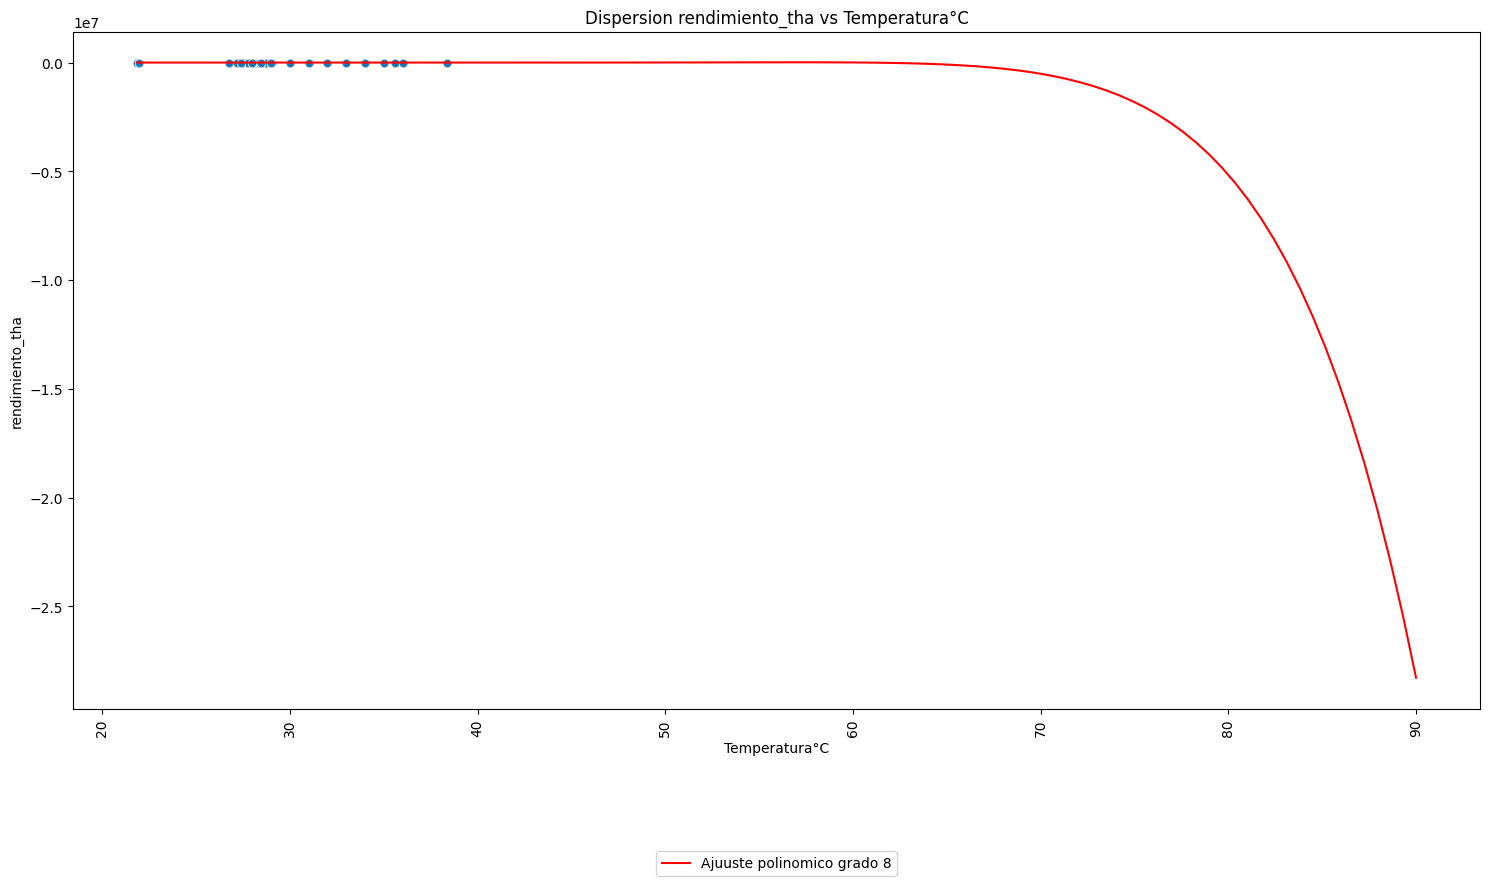

In [ ]:
# display of  polynomial transformation
Lista_grafico_dispersion=['Precipitación mm','Humedad %','Temperatura°C']

for i in Lista_grafico_dispersion:
    graf_dispersion_poli(df_agri_n,i,'rendimiento_tha','cultivo', grado=8)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Mean Squared Error: 60.70306128149439
Root Mean Squared Error: 7.79
Mean Squared Error: 60.70306128149439
Root Mean Squared Error: 7.79


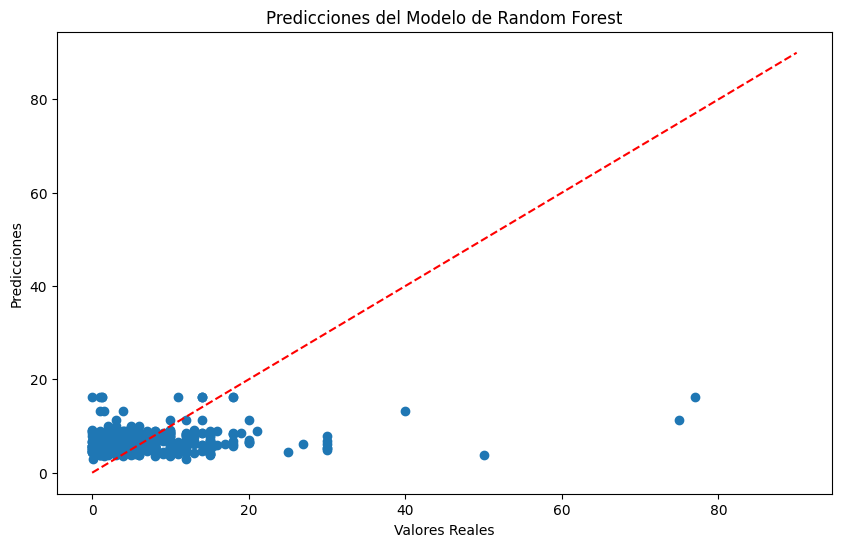

In [ ]:
# Implementation of random forest
# Split the data into training and testing sets
X = df_agri_n[['Precipitación mm']]  # Independent variable
y = df_agri_n['rendimiento_tha']      # Dependent variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
modelo_rf = RandomForestRegressor(n_estimators=500, random_state=10)
modelo_rf.fit(X_train, y_train)

# Predictions
y_pred = modelo_rf.predict(X_test)

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = np.mean((y_test - y_pred) ** 2)
print(f'Mean Squared Error: {mse}')
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse:.2f}')

# Evaluate the model
mse = np.mean((y_test - y_pred) ** 2)
print(f'Mean Squared Error: {mse}')
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse:.2f}')

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title('Random Forest Model Predictions')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')  # Reference line
plt.show()


In [ ]:
# we will group them by municipality and draw the top 5 
def contador (df,columna): 

    cuenta= df[columna].value_counts().reset_index()
    cuenta.columns= [columna, 'count'] #save value
    cuenta= cuenta.sort_values(by= 'count', ascending = False) #sort columns
    return cuenta 

In [96]:
rank_municipios= contador (df_agri_n,'municipio')
rank_municipios.head(20)

municipio  count
0            san jacinto    134
1    cartagena de indias    121
2                mahates    100
3                   achi     94
4         santa catalina     89
5             santa rosa     86
6   el carmen de bolivar     85
7          maria la baja     77
8            montecristo     75
9              san pablo     69
10              magangue     67
11              el peñon     65
12              pinillos     63
13              el guamo     63
14               morales     58
15            villanueva     57
16    santa rosa del sur     57
17               turbaco     53
18               regidor     53
19             clemencia     53

In [53]:
contador(df_agri_p,'cultivo')

cultivo  count
0    maiz tradicional    305
1                yuca    301
2                maiz    193
3             platano    185
4              frijol    167
..                ...    ...
60       tabaco rubio      2
61            achiote      2
62    yuca industrial      1
63             pepino      1
64  flores y follajes      1

[65 rows x 2 columns]

In [27]:
top_municipios = ['san jacinto','cartagena de indias','mahates','achi','santa catalina']
top_cultivos= ['yuca','maiz tradicional','maiz','platano','frijol']
#'arroz','mango','ñame','ahuyama','arroz secano manual'
#df solo del top 5 de municipios 
#filtra los 5 municipios
tmunicipio = df_agri_n[df_agri_n['municipio'].isin(top_municipios)]
tcultivos = df_agri_n[df_agri_n['cultivo'].isin(top_cultivos)]

In [109]:
tcultivos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 955 entries, 11 to 2623
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   coddpto            955 non-null    int64  
 1   departamento       955 non-null    object 
 2   codmunicipio       955 non-null    object 
 3   municipio          955 non-null    object 
 4   cultivo            955 non-null    object 
 5   periodo            955 non-null    int64  
 6   area_sembrada_ha   955 non-null    float64
 7   area_cosechada_ha  955 non-null    float64
 8   produccion_t       955 non-null    float64
 9   rendimiento_tha    955 non-null    float64
 10  Precipitación mm   955 non-null    float64
 11  Humedad %          955 non-null    float64
 12  Temperatura°C      955 non-null    float64
dtypes: float64(7), int64(2), object(4)
memory usage: 104.5+ KB


In [ ]:
# let´s group by  top of crops
mun_goup= tcultivos.groupby(['cultivo']).agg({
    'produccion_t': 'first',
    'Precipitación mm': 'first',   
    'Humedad %': 'first',         
    'Temperatura°C': 'first',
    'rendimiento_tha':'first'#,
    #'area_sembrada_ha':'first',
    #'area_cosechada_ha':'first'#,
    #'municipio': 'first',
    #'periodo':'first'


}).sort_values(by= 'rendimiento_tha', ascending= False).reset_index(drop=False)

In [110]:
mun_goup.describe()

produccion_t  Precipitación mm   Humedad %  Temperatura°C  \
count      5.000000          5.000000    5.000000       5.000000   
mean    3142.000000       4068.912000   92.000000      29.600000   
std     2549.964706       1633.847661    4.472136       0.894427   
min       10.000000       1281.560000   90.000000      28.000000   
25%     1600.000000       3914.500000   90.000000      30.000000   
50%     3000.000000       5049.500000   90.000000      30.000000   
75%     4500.000000       5049.500000   90.000000      30.000000   
max     6600.000000       5049.500000  100.000000      30.000000   

       rendimiento_tha  
count         5.000000  
mean          4.300000  
std           4.438468  
min           1.000000  
25%           2.000000  
50%           2.500000  
75%           4.000000  
max          12.000000

In [61]:
muestra = mun_goup#.dropna(subset=['Precipitación mm','Humedad %','Temperatura°C'])

In [371]:
muestra =muestra[ muestra['area_cosechada_ha']>30]

In [372]:
muestra

cultivo  rendimiento_tha  produccion_t  Precipitación mm  \
3             patilla            60.00       3060.00        555.000000   
17            patilla            30.00       1200.00        175.333333   
18               yuca            29.00      17400.00        194.000000   
19    palma de aceite            28.00     279888.00       1982.142857   
20               yuca            28.00       4480.00        275.000000   
..                ...              ...           ...               ...   
478  frijol arbustivo             0.35         14.00        555.000000   
480             cacao             0.20         12.00       1669.046429   
481             cacao             0.13         24.77       1954.500000   
482             cacao             0.10         13.00       1872.950000   
500              cafe             0.00         32.00        144.000000   

      Humedad %  Temperatura°C  area_sembrada_ha  area_cosechada_ha  
3     98.000000      34.000000              55.0               51.0  
17    95.333333      34.333333              50.0               40.0  
18    75.000000      34.000000             750.0              600.0  
19   100.000000      34.000000           11107.0             9996.0  
20    86.000000      36.000000             163.0              160.0  
..          ...            ...               ...                ...  
478   98.000000      34.000000              40.0               40.0  
480   88.967591      30.364594              73.0               58.0  
481   95.000000      35.000000             240.5              190.5  
482   95.000000      35.000000             190.0              130.0  
500  100.000000      33.000000             101.0               81.0  

[257 rows x 8 columns]

In [ ]:
# we calculate correlation for the top 5 municipalities - Pearson 
Lista_grafico_dispersion=['Precipitación mm','Humedad %','Temperatura°C']

for i in Lista_grafico_dispersion:
    pearson_coef,_= pearsonr(muestra[i],muestra['rendimiento_tha'])
    print(f'Coeficiente de Pearson {i}:',pearson_coef)

Coeficiente de Pearson Precipitación mm: 0.5186554248495577
Coeficiente de Pearson Humedad %: -0.4156289955343996
Coeficiente de Pearson Temperatura°C: 0.41562899553439964


In [ ]:
# we calculate correlation for the top 5 municipalities - Spearman 
Lista_grafico_dispersion=['Precipitación mm','Humedad %','Temperatura°C']

for i in Lista_grafico_dispersion:
    spearman_coef,_= spearmanr(muestra['rendimiento_tha'],muestra[i])
    print(f'Coeficiente de Spearman {i};',spearman_coef)

Coeficiente de Spearman Precipitación mm; 0.8944271909999157
Coeficiente de Spearman Humedad %; -0.7071067811865475
Coeficiente de Spearman Temperatura°C; 0.7071067811865475


In [ ]:
# given that the relationship between the data is not linear - TOP 5 CROPS 
# we calculate the kendall's correlation coefficient
Lista_grafico_dispersion=['Precipitación mm','Humedad %','Temperatura°C']

for i in Lista_grafico_dispersion:
    kendall_coef, p_valor_kendall = kendalltau(mun_goup[i],mun_goup['rendimiento_tha'])
    print(f'Coeficiente de Kendall {i}: {kendall_coef}, p_valor:{p_valor_kendall}')


Coeficiente de Kendall Precipitación mm: 0.8366600265340755, p_valor:0.05220363534131463
Coeficiente de Kendall Humedad %: -0.6324555320336759, p_valor:0.15729920705028516
Coeficiente de Kendall Temperatura°C: 0.6324555320336759, p_valor:0.15729920705028516


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Mean Squared Error: 0.09481267361111094
Root Mean Squared Error: 0.31


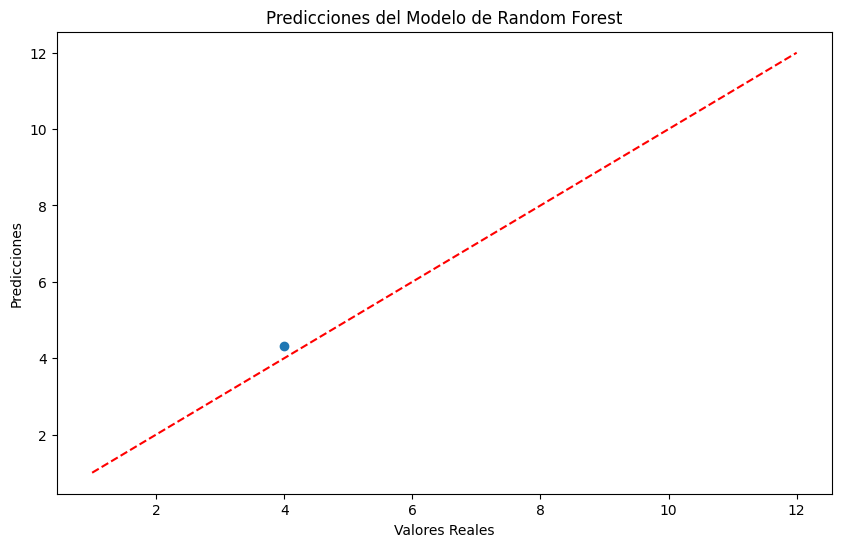

In [ ]:
# Implementation of random forest - top 5 crops
# Split the data into training and testing sets
X = mun_goup[['Precipitación mm']]  # Independent variable
y = mun_goup['rendimiento_tha']      # Dependent variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Assuming your data is already in X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), 
                           param_grid=param_grid, 
                           cv=3,  # Change to 3 or less
                           scoring='neg_mean_squared_error', 
                           verbose=2, 
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = np.mean((y_test - y_pred) ** 2)
print(f'Mean Squared Error: {mse}')
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse:.2f}')

# Plot results
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title('Random Forest Model Predictions')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')  # Reference line
plt.show()


C:\Users\Cristin Rodriguez\AppData\Local\Temp\ipykernel_22200\388702444.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(0.5,-0.2), loc='upper center', ncol=6 )


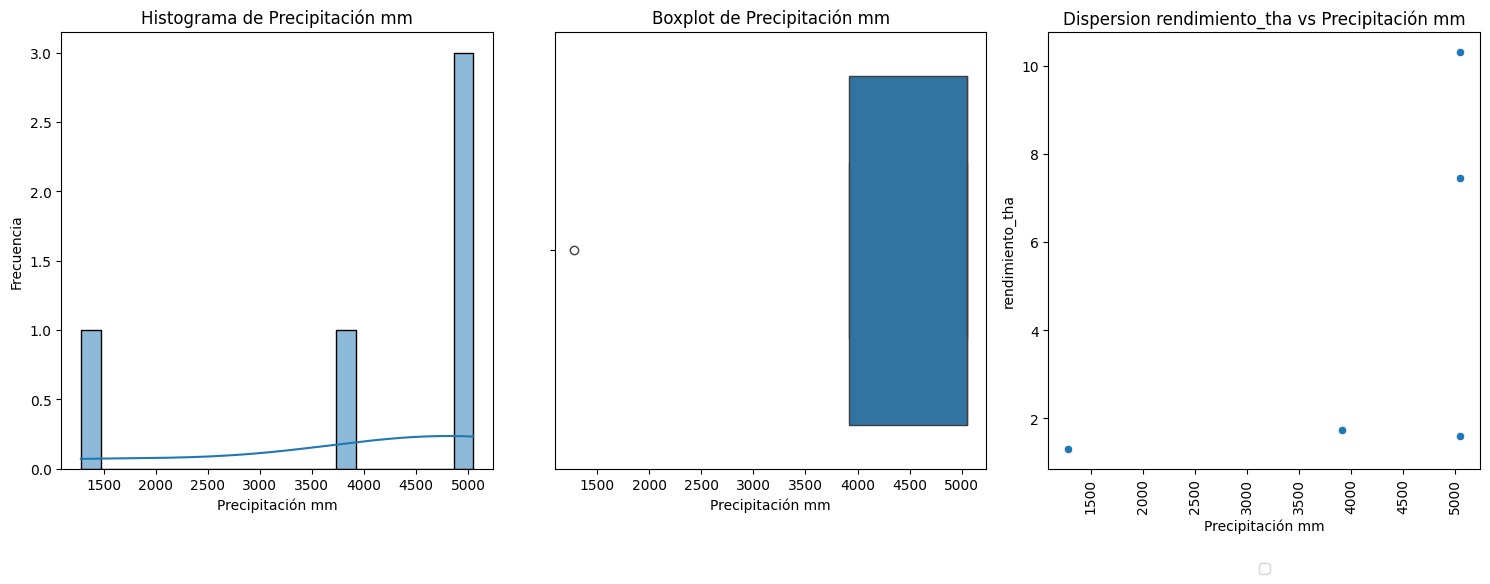

C:\Users\Cristin Rodriguez\AppData\Local\Temp\ipykernel_22200\388702444.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(0.5,-0.2), loc='upper center', ncol=6 )


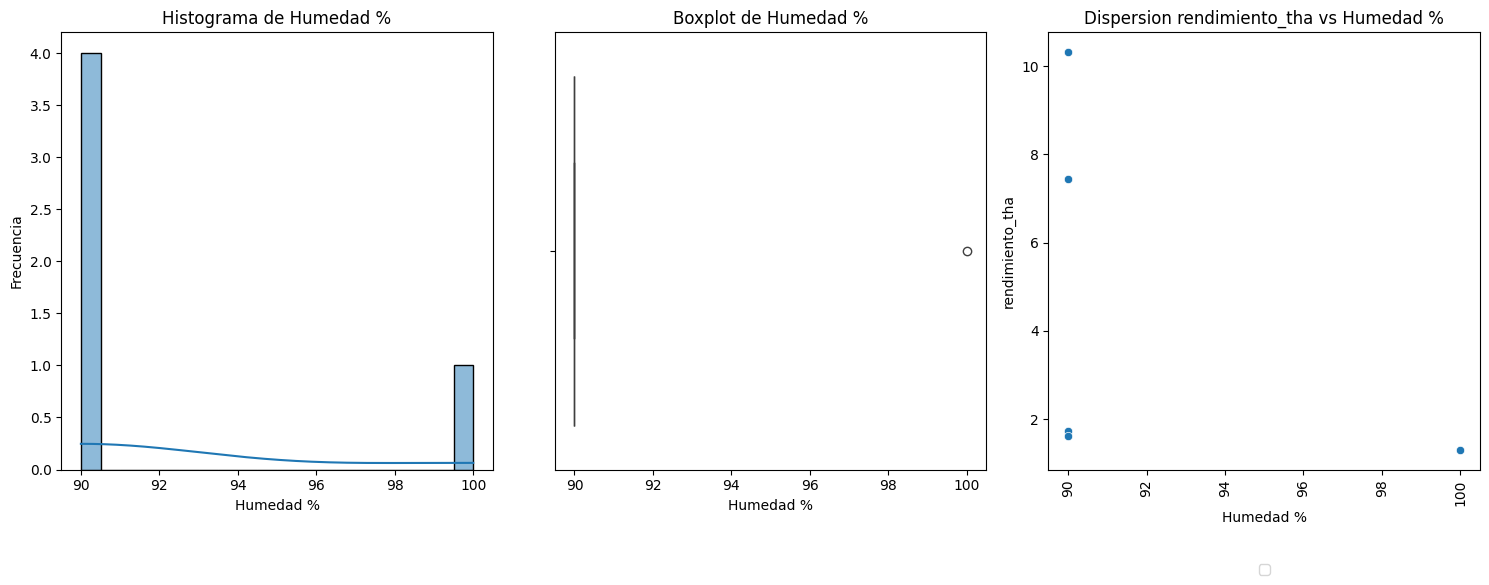

C:\Users\Cristin Rodriguez\AppData\Local\Temp\ipykernel_22200\388702444.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(0.5,-0.2), loc='upper center', ncol=6 )


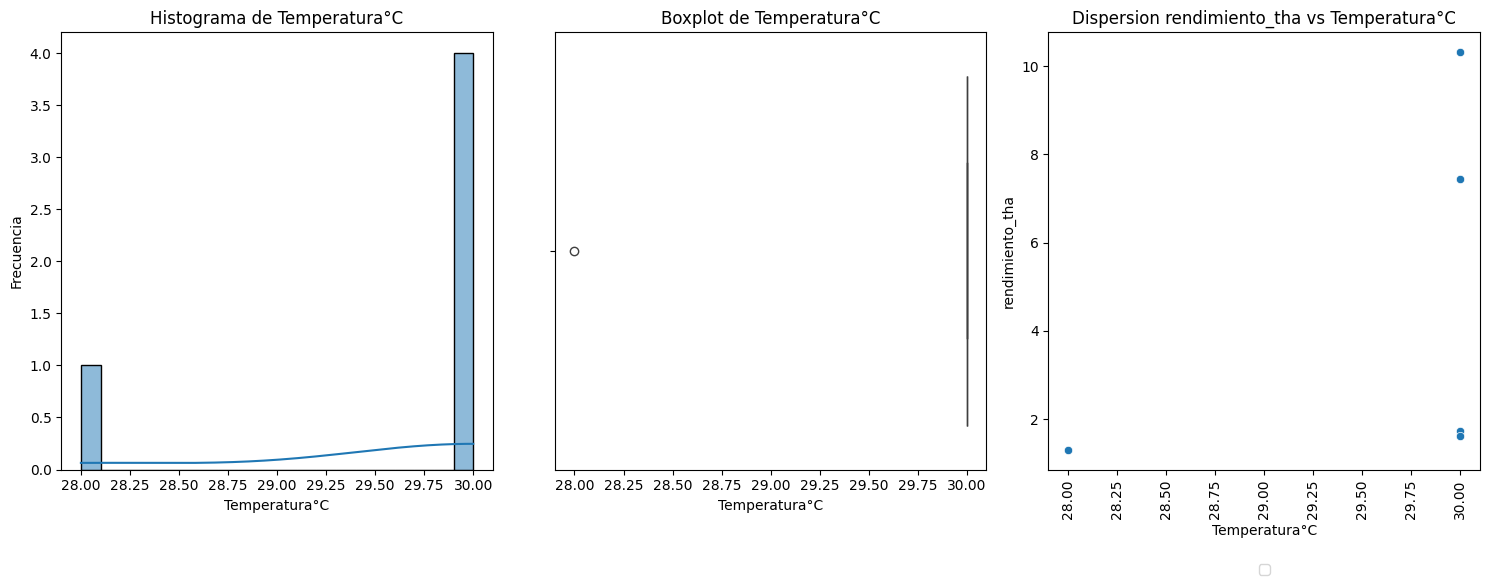

In [ ]:
# Graphical analysis of dispersion
Lista_grafico=['Precipitación mm','Humedad %','Temperatura°C']

for i in Lista_grafico:
    analisis_grafico(mun_goup,i,'rendimiento_tha','municipio')

In [73]:
# FUNCION DE MAPA DE CALOR 

def mapa_calor (df):
    df=df.select_dtypes(include=['float64','int64'])
    #conficuración del lienzo 
    plt.figure(figsize=(10,8))
    # configuación de mapa de calor 
    sns.heatmap(df,annot=True,cmap='coolwarm',linewidths=0.5,fmt='.2f')
  
    plt.show()

In [383]:
profile = ProfileReport(df_agri_n,title='informe')

In [384]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
 #Group the data by municipality and period
# Temporal comparison of agricultural yields by year
# Group by the top crop
grupo_temporal = df_agri_n.groupby(['periodo', 'municipio']).agg({
    #'produccion_t': 'first',
    #'Precipitación mm': 'mean',  
    #'Humedad %': 'mean',          
    #'Temperatura°C': 'mean',
    'rendimiento_tha': 'mean'  # Mean yield
    #'area_sembrada_ha': 'first',
    #'area_cosechada_ha': 'first'  # First value (not relevant here)
    #'municipio': 'first',
    #'periodo': 'first'
}).reset_index(drop=False)

# Sort by yield in descending order
grupo_temporal.sort_values(by='rendimiento_tha', ascending=False)


periodo            municipio  rendimiento_tha
3       2016               arjona        40.000000
187     2020           villanueva        23.727273
149     2019           villanueva        19.714286
98      2018              regidor        18.871250
159     2020  cartagena de indias        14.320000
..       ...                  ...              ...
112     2018             zambrano         2.421667
28      2016               simiti         2.340000
106     2018               simiti         2.244000
73      2017             zambrano         2.200000
34      2016             zambrano         1.600000

[189 rows x 3 columns]

In [ ]:
# line graph to visualise the evolution of agricultural yields over time for each municipality.
def grafico_linea(df,columnax, columnay,leyenda):
    
    #canvas set

    plt.figure(figsize=(12,6))
    sns.lineplot(data=df, x=columnax,y=columnay , hue=leyenda, marker= 'o')

    plt.title('comparación temporal del rendimiento agricola por municipio')
    plt.xlabel('periodo')
    plt.ylabel('Rendimiento Promedio')
    plt.xticks(rotation=45)
    plt.legend(title='leyenda',bbox_to_anchor=(0.5,-0.2), loc='upper center', ncol=6) 
    plt.grid()
    plt.show()   


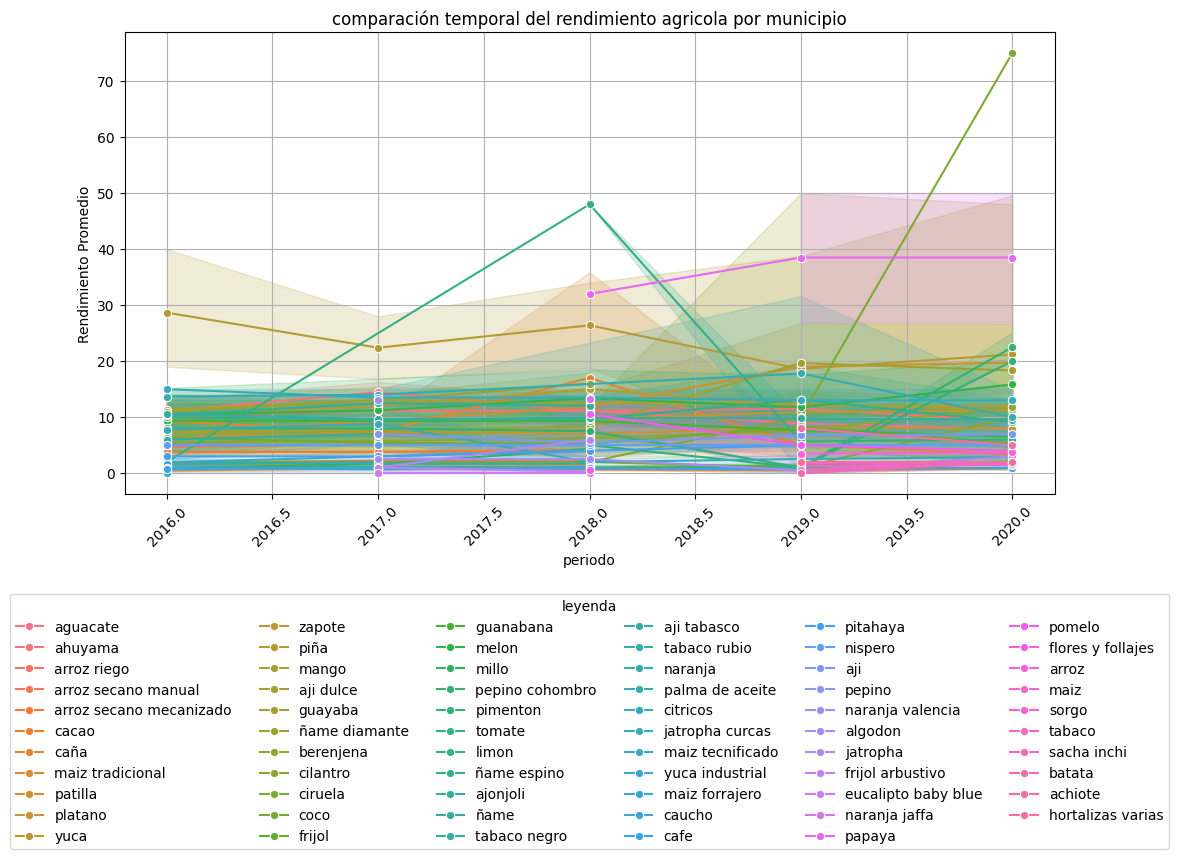

In [77]:
grafico_linea(df_agri_n,'periodo','rendimiento_tha','cultivo')

C:\Users\Cristin Rodriguez\AppData\Local\Temp\ipykernel_15200\3775120872.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




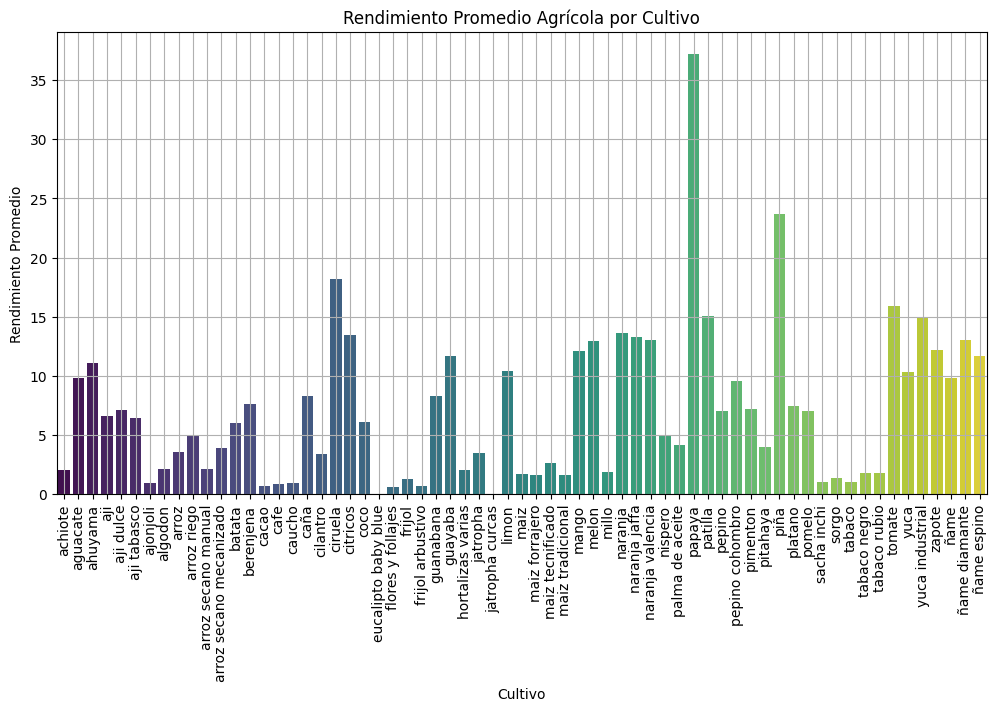

In [ ]:
#  Calculate of mean yield  per municupality
df_municipio = df_agri_n.groupby('cultivo').agg({'rendimiento_tha': 'mean'}).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=df_municipio, x='cultivo', y='rendimiento_tha', palette='viridis')

plt.title('Rendimiento Promedio Agrícola por Cultivo')
plt.xlabel('Cultivo')
plt.ylabel('Rendimiento Promedio')
plt.xticks(rotation=90)
plt.grid()
plt.show()


In [ ]:
# spatial analysis with geopandas
# load geojson file
gdf_municipios = gpd.read_file("C:/Users/Cristin Rodriguez/Downloads/shapes.geojson")

In [102]:
gdf_municipios.rename(columns={'nombre_mpi':'municipio'},inplace=True)

In [103]:
gdf_municipios['municipio']=gdf_municipios['municipio'].str.lower()

In [96]:
gdf_municipios.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   geo_point_2d  45 non-null     object  
 1   area          45 non-null     float64 
 2   perimeter     45 non-null     float64 
 3   dpto          45 non-null     object  
 4   nombre_dpt    45 non-null     object  
 5   mpio          45 non-null     object  
 6   municipio     45 non-null     object  
 7   nombre_cab    45 non-null     object  
 8   mpios         45 non-null     object  
 9   hectares      45 non-null     float64 
 10  geometry      45 non-null     geometry
dtypes: float64(3), geometry(1), object(7)
memory usage: 4.0+ KB


In [ ]:
# union of df by municipality and geography 
gdf_municipios = gdf_municipios.merge(df_municipio,how='left',on='municipio')

In [ ]:
# Create the map with Plotly
fig = px.choropleth(
    gdf_municipios,
    geojson=gdf_municipios.geometry,
    locations=gdf_municipios.index,
    color='rendimiento_tha',
    hover_name='municipio',
    color_continuous_scale="OrRd",
    labels={'rendimiento_tha': 'Average Yield'},
    title='Heatmap of Agricultural Yield by Municipality'
)

# Configure the layout
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})

# Show the map
fig.show()


In [443]:
gdf_municipios.head()

geo_point_2d          area  \
0  { "lon": -74.306258132638206, "lat": 8.4780123...  8.627114e+08   
1  { "lon": -74.244686148938598, "lat": 7.3127232...  1.141810e+09   
2  { "lon": -75.205330364286255, "lat": 10.339790...  1.919895e+08   
3  { "lon": -75.261487230342709, "lat": 10.415918...  1.573980e+08   
4  { "lon": -75.438653441483567, "lat": 10.206616...  1.833772e+08   

       perimeter dpto nombre_dpt mpio       municipio      nombre_cab  mpios  \
0  127857.374064   13    BOLIVAR  810        tiquisio     PUERTO RICO  13810   
1  211596.746659   13    BOLIVAR  670       san pablo       SAN PABLO  13670   
2   58911.254394   13    BOLIVAR  647  san estanislao  SAN ESTANISLAO  13647   
3   52688.676973   13    BOLIVAR  873      villanueva      VILLANUEVA  13873   
4   58180.580429   13    BOLIVAR  838         turbana         TURBANA  13838   

     hectares                                           geometry  \
0   86271.144  POLYGON ((-74.1479 8.6455, -74.1375 8.6408, -7...   
1  114180.990  POLYGON ((-73.88985 7.5185, -73.8954 7.5071, -...   
2   19198.952  POLYGON ((-75.1854 10.4434, -75.1693 10.434, -...   
3   15739.801  POLYGON ((-75.2978 10.4692, -75.2898 10.4698, ...   
4   18337.723  POLYGON ((-75.447 10.2821, -75.4326 10.2809, -...   

   rendimiento_tha  
0         4.181818  
1         5.647101  
2         9.396226  
3        16.080702  
4         4.900000

In [444]:
df_agri_n.to_csv('Rendimiento agricultor y Variables Climaticas.csv')

In [ ]:

df_geo_agri = gdf_municipios.merge(df_agri_n,how='left',on='municipio')

In [24]:
df_geo_agri.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2137 entries, 0 to 2136
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   geo_point_2d       2137 non-null   object  
 1   area               2137 non-null   float64 
 2   perimeter          2137 non-null   float64 
 3   dpto               2137 non-null   object  
 4   nombre_dpt         2137 non-null   object  
 5   mpio               2137 non-null   object  
 6   municipio          2137 non-null   object  
 7   nombre_cab         2137 non-null   object  
 8   mpios              2137 non-null   object  
 9   hectares           2137 non-null   float64 
 10  geometry           2137 non-null   geometry
 11  coddpto            2130 non-null   float64 
 12  departamento       2130 non-null   object  
 13  codmunicipio       2130 non-null   object  
 14  cultivo            2130 non-null   object  
 15  periodo            2130 non-null   float64 
 16

In [25]:
df_geo_agri.to_csv('Rendimiento_agricultor_Variables_Climaticas_Geoespaciales.csv')